In [1]:
import pandas as pd
import numpy as np
import os, time, stat, io, glob, pickle
from scipy.stats import gamma, norm
from sklearn.linear_model import LinearRegression

from IPython.core.display import display, HTML

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('fivethirtyeight')
import plotly.io as pio

%load_ext autoreload
%autoreload 2
from covid_data_helper import *
from coronita_chart_helper import *
from coronita_model_helper import *

from matplotlib.backends.backend_pdf import PdfPages
from PyPDF2 import PdfFileWriter, PdfFileReader

def footnote_str_maker():
    footnote_str = 'Author: Michael Donnelly | twtr: @donnellymjd | www.covidoutlook.info\nChart created on {}'.format(
        pd.Timestamp.today().strftime("%d %b, %Y at %I:%M %p"))
    return footnote_str

def add_plotly_footnote(fig):
    fig.update_layout(
                  annotations=[
                      dict(x = 0, y = -0.06, font_size=10, showarrow=False,
                           xref='paper', yref='paper',
                           xanchor='left', yanchor='auto', xshift=0, yshift=0,
                           text='Author: Michael Donnelly | twtr: <a href="https://twitter.com/donnellymjd">@donnellymjd</a> | <a href="http://{0}">{0}</a>'.format(
                           'www.michaeldonnel.ly')
                          ),
                      dict(x = 0, y = -0.09, font_size=10, showarrow=False,
                           xref='paper', yref='paper',
                           xanchor='left', yanchor='auto', xshift=0, yshift=0,
                           text='Chart created on {}'.format(pd.Timestamp.today().strftime("%d %b %Y"))
                          )
                  ]
                 )
    return fig


In [2]:
nyregionmap = {county:x for x,y in get_nyregionmap().items() for county in y}
for county in ['Bronx', 'Kings', 'New York', 'Queens', 'Richmond']:
    nyregionmap[county] = 'NYC'
for county in ['Monroe','Erie','Albany','Onondaga']:
    nyregionmap[county] = 'Upstate Cities'


Got NYT county level data.


In [3]:
df_census = get_census_pop()
df_census.head()

Got Census Data


,state,county,fips,SUMLEV,REGION,DIVISION,pop2019
0,AL,Alabama,01000,40,3,6,4903185
1,AL,Autauga,01001,50,3,6,55869
2,AL,Baldwin,01003,50,3,6,223234
3,AL,Barbour,01005,50,3,6,24686
4,AL,Bibb,01007,50,3,6,22394


In [4]:
df_counties = get_complete_county_data() #get_nyt_counties()
df_counties.head()


Got NYS DOH data
Got Census Data
Got NYT county level data.
Got NYC DOH data
Got Google Movement Data
Got Complete County Data


pop2019  cases  deaths  cases_per100k  \
dt         state county    fips                                             
2020-01-21 WA    Snohomish 53061   822083.0    1.0     0.0       0.121642   
2020-01-22 WA    Snohomish 53061   822083.0    1.0     0.0       0.121642   
2020-01-23 WA    Snohomish 53061   822083.0    1.0     0.0       0.121642   
2020-01-24 IL    Cook      17031  5150233.0    1.0     0.0       0.019417   
           WA    Snohomish 53061   822083.0    1.0     0.0       0.121642   

                                  retail_and_recreation_percent_change_from_baseline  \
dt         state county    fips                                                        
2020-01-21 WA    Snohomish 53061                                                NaN    
2020-01-22 WA    Snohomish 53061                                                NaN    
2020-01-23 WA    Snohomish 53061                                                NaN    
2020-01-24 IL    Cook      17031                                                NaN    
           WA    Snohomish 53061                                                NaN    

                                  grocery_and_pharmacy_percent_change_from_baseline  \
dt         state county    fips                                                       
2020-01-21 WA    Snohomish 53061                                                NaN   
2020-01-22 WA    Snohomish 53061                                                NaN   
2020-01-23 WA    Snohomish 53061                                                NaN   
2020-01-24 IL    Cook      17031                                                NaN   
           WA    Snohomish 53061                                                NaN   

                                  parks_percent_change_from_baseline  \
dt         state county    fips                                        
2020-01-21 WA    Snohomish 53061                                 NaN   
2020-01-22 WA    Snohomish 53061                                 NaN   
2020-01-23 WA    Snohomish 53061                                 NaN   
2020-01-24 IL    Cook      17031                                 NaN   
           WA    Snohomish 53061                                 NaN   

                                  transit_stations_percent_change_from_baseline  \
dt         state county    fips                                                   
2020-01-21 WA    Snohomish 53061                                            NaN   
2020-01-22 WA    Snohomish 53061                                            NaN   
2020-01-23 WA    Snohomish 53061                                            NaN   
2020-01-24 IL    Cook      17031                                            NaN   
           WA    Snohomish 53061                                            NaN   

                                  workplaces_percent_change_from_baseline  \
dt         state county    fips                                             
2020-01-21 WA    Snohomish 53061                                      NaN   
2020-01-22 WA    Snohomish 53061                                      NaN   
2020-01-23 WA    Snohomish 53061                                      NaN   
2020-01-24 IL    Cook      17031                                      NaN   
           WA    Snohomish 53061                                      NaN   

                                  residential_percent_change_from_baseline  
dt         state county    fips                                             
2020-01-21 WA    Snohomish 53061                                       NaN  
2020-01-22 WA    Snohomish 53061                                       NaN  
2020-01-23 WA    Snohomish 53061                                       NaN  
2020-01-24 IL    Cook      17031                                       NaN  
           WA    Snohomish 53061                                       NaN

In [5]:
df_nys_pub = get_nysdoh_data()
df_nys_pub.head()

Got NYS DOH data


new_positives  cumulative_number_of_positives  \
county dt                                                          
Albany 2020-03-01              0                               0   
       2020-03-02              0                               0   
       2020-03-03              0                               0   
       2020-03-04              0                               0   
       2020-03-05              0                               0   

                   total_number_of_tests_performed  \
county dt                                            
Albany 2020-03-01                                0   
       2020-03-02                                0   
       2020-03-03                                0   
       2020-03-04                                0   
       2020-03-05                                3   

                   cumulative_number_of_tests_performed  
county dt                                                
Albany 2020-03-01                                     0  
       2020-03-02                                     0  
       2020-03-03                                     0  
       2020-03-04                                     0  
       2020-03-05                                     3

In [6]:
counties_geo = get_counties_geo()

Got counties geo json


In [7]:
# df_counties_enhanced = pd.merge(
#     df_census[df_census.SUMLEV==50], 
#     df_counties.reset_index()[['dt','fips','cases','deaths']], 
#     on='fips', how='left')
# df_counties_enhanced['cases_per100k']= df_counties_enhanced['cases'].mul(1e5).div(df_counties_enhanced['pop2019'])
# df_counties_enhanced.head()


In [8]:
df_goog_mob_us = get_goog_mvmt_us()
df_goog_mob_state = get_goog_mvmt_state(df_goog_mob_us)
df_goog_mob_us = df_goog_mob_us[df_goog_mob_us.state.isnull()].set_index('dt')
df_goog_mob_state.head()

Got Google Movement Data


retail_and_recreation_percent_change_from_baseline  \
state dt                                                               
AL    2020-02-15                                                5.0    
      2020-02-16                                                0.0    
      2020-02-17                                                3.0    
      2020-02-18                                               -4.0    
      2020-02-19                                                4.0    

                  grocery_and_pharmacy_percent_change_from_baseline  \
state dt                                                              
AL    2020-02-15                                                2.0   
      2020-02-16                                               -2.0   
      2020-02-17                                                0.0   
      2020-02-18                                               -3.0   
      2020-02-19                                                1.0   

                  parks_percent_change_from_baseline  \
state dt                                               
AL    2020-02-15                                39.0   
      2020-02-16                                -7.0   
      2020-02-17                                17.0   
      2020-02-18                               -11.0   
      2020-02-19                                 6.0   

                  transit_stations_percent_change_from_baseline  \
state dt                                                          
AL    2020-02-15                                            7.0   
      2020-02-16                                            3.0   
      2020-02-17                                            7.0   
      2020-02-18                                           -1.0   
      2020-02-19                                            4.0   

                  workplaces_percent_change_from_baseline  \
state dt                                                    
AL    2020-02-15                                      2.0   
      2020-02-16                                     -1.0   
      2020-02-17                                    -17.0   
      2020-02-18                                      1.0   
      2020-02-19                                      1.0   

                  residential_percent_change_from_baseline  
state dt                                                    
AL    2020-02-15                                      -1.0  
      2020-02-16                                       1.0  
      2020-02-17                                       4.0  
      2020-02-18                                       2.0  
      2020-02-19                                       0.0

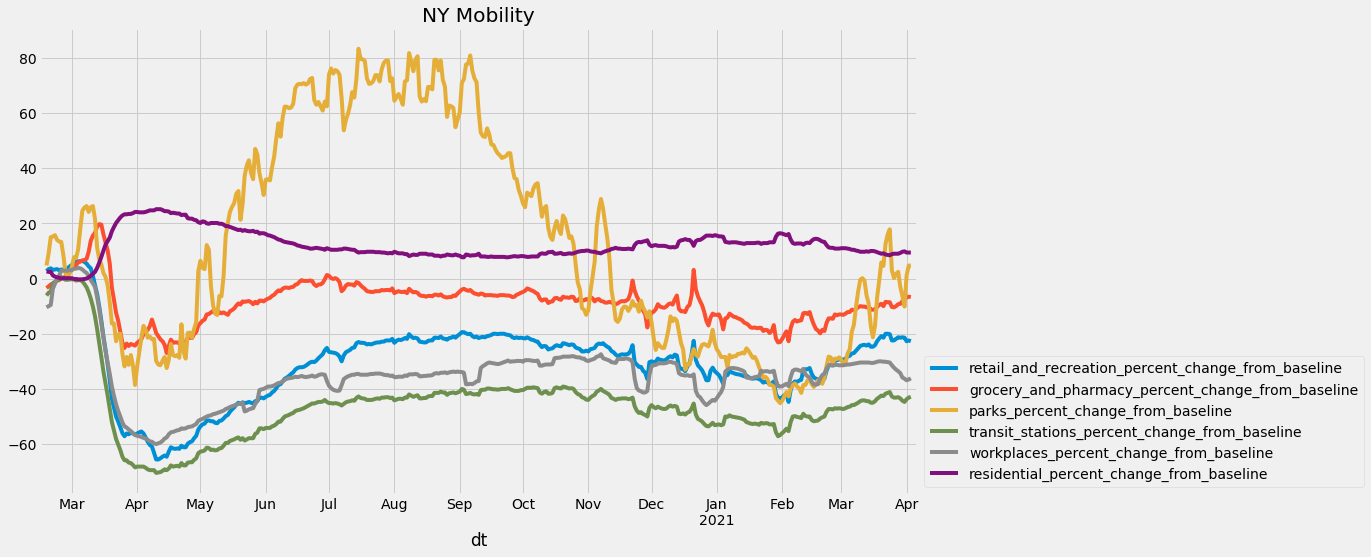

In [9]:
state = 'NY' 
df_chart = df_goog_mob_state.loc[state].rolling(7, center=True).mean()
ax = df_chart.plot(figsize=[14,8], title='{} Mobility'.format(state))

plt.legend(loc='lower left', bbox_to_anchor=(1., 0))

In [10]:
list_of_files = glob.glob('./output/nys_fore/df_fore_allregions_*.pkl') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
df_fore_allregions = pd.read_pickle(latest_file)


./output/nys_fore/df_fore_allregions_20210405.pkl


In [11]:
list_of_files = glob.glob('./output/nys_fore/allregion_model_dicts_*.pkl') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
with open(latest_file, 'rb') as handle:
    allregion_model_dicts = pickle.load(handle)
    

./output/nys_fore/allregion_model_dicts_20210405.pkl


In [12]:
list_of_files = glob.glob('./data/202*-NYS-COVID-19-Data-vShare.xlsx')
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
dict_of_dfs = pd.read_excel(latest_file, sheet_name=None, skiprows=0, engine='openpyxl')


./data/20210405-NYS-COVID-19-Data-vShare.xlsx


In [13]:
list_of_files = glob.glob('./data/*-Interventions-v*.xlsx')
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
df_interventions = pd.read_excel(latest_file, engine='openpyxl').iloc[:,1:]

df_interventions = df_interventions.rename(columns={'Date':'dt','Region(s)':'region','Event':'event_name'})
keepevents = ['State of emergency declaration','Schools closed','Closure of non-essential businesses']
df_interventions = df_interventions[((df_interventions.region == 'Statewide (all)') 
                        & (df_interventions.event_name.isin(keepevents))) 
                       | (df_interventions.region != 'Statewide (all)')]
df_interventions['social_distancing_direction'] = 'holiday'
df_interventions.head()


./data/20210405-Interventions-v1000.xlsx


,dt,region,event_name,Source Title,Source Link,social_distancing_direction
3,2020-03-07,Statewide (all),State of emergency declaration,NYS EO 202,https://www.governor.ny.gov/news/no-202-declar...,holiday
9,2020-03-18,Statewide (all),Schools closed,NYS EO 202.4,https://www.governor.ny.gov/news/no-2024-conti...,holiday
13,2020-03-22,Statewide (all),Closure of non-essential businesses,NYS EO 202.8,https://www.governor.ny.gov/news/no-2028-conti...,holiday
14,2020-05-15,Central New York,Phase I re-opening (Construction and Manufactu...,NYS EO 202.31,https://www.governor.ny.gov/news/no-20231-cont...,holiday
15,2020-05-15,Finger Lakes,Phase I re-opening (Construction and Manufactu...,NYS EO 202.31,https://www.governor.ny.gov/news/no-20231-cont...,holiday


In [14]:
def read_nys_priv_hist_data(df_hist, nyregionmap, skiprows=1, df_census=df_census):
    df_hist.columns = df_hist.iloc[skiprows-1]
    df_hist = df_hist.iloc[skiprows:].copy()
    df_hist['County'] = df_hist['County'].replace({'St.Lawrence':'St. Lawrence'})
    df_hist.columns.name = 'dt'
    df_hist = df_hist.loc[df_hist['County'] !='Total'].dropna(how='all')
    
    if 'Region' in df_hist.columns:
        df_hist = df_hist.loc[~df_hist['Region'].isnull()]
    else:
        df_hist['nys_region'] = np.nan
    
    if 'Governor\'s Economic Region' not in df_hist.columns:
        df_hist['gov_econ_region'] = np.nan
    
    df_hist = df_hist.rename(columns = {'County':'county', 
                              'Region':'nys_region',
                              'Governor\'s Economic Region':'gov_econ_region'})
    df_hist['mjd_region'] = df_hist['county'].replace(nyregionmap)
    df_hist = df_hist.set_index(['county', 'mjd_region', 'nys_region', 'gov_econ_region'])
    df_hist = pd.to_numeric(df_hist.stack('dt'), errors='coerce')
    df_hist = df_hist.reset_index()
    df_hist['dt'] = pd.to_datetime(df_hist['dt']).dt.normalize()
    df_hist = df_hist.set_index(['county', 'mjd_region', 'nys_region', 'gov_econ_region','dt'])
    
    df_ny_pop = df_census[(df_census.state=='NY') & (df_census.SUMLEV==50)].copy()
    df_ny_pop = pd.merge(
        df_hist.reset_index()[['county', 'mjd_region', 'nys_region', 'gov_econ_region']].drop_duplicates(),
        df_ny_pop, 
        on='county', how='left')
    
    return df_hist

def get_nys_static_data(df_census, nyregionmap):
    df_ny_pop = df_census.loc[(df_census['state']=='NY') & (df_census['SUMLEV']==50),
                             ['state','county','fips','pop2019']].copy()
    df_ny_pop['mjd_region'] = df_ny_pop['county'].replace(nyregionmap)
    df_ny_pop = pd.merge(df_ny_pop,
                         df_nys.reset_index()[['county','nys_region','gov_econ_region']].drop_duplicates(),
                         on='county', how='left'
                        )
    return df_ny_pop


In [15]:
df_nys = pd.DataFrame()

for tab in dict_of_dfs.keys():
    print(tab)
    if tab in ['Summary', 'ICU county', 'BED county']: #,'New hosp death_county_occurred']:
        print('passing this one: ', tab)
        pass
#     elif tab in ['Cumulative hosp deaths_county', 
#                  'Chng hosp death_county_reported',
#                  'New_hosp_admissions_county',
#                  'Daily tests_county',
#                  'Positive tests_county'
#                 ]:
#         this_tab = read_nys_priv_hist_data(dict_of_dfs[tab], nyregionmap, 2)
#         df_nys = pd.concat([df_nys, pd.DataFrame(this_tab, columns=[tab])])
    else:
        try:
            this_tab = read_nys_priv_hist_data(dict_of_dfs[tab], nyregionmap, 1)
        except:
            this_tab = read_nys_priv_hist_data(dict_of_dfs[tab], nyregionmap, 2)
        this_tab.columns = ['value']
        this_tab['metric'] = tab
        df_nys = pd.concat([df_nys, this_tab], axis=0)

df_ny_pop = get_nys_static_data(df_census, nyregionmap)
df_nys = df_nys.reset_index().set_index(
    ['county', 'mjd_region', 'nys_region', 'gov_econ_region','dt','metric']).unstack('metric')['value']
df_nys = df_nys.sort_index()

display(df_ny_pop.head())
display(df_nys.head())


Summary
passing this one:  Summary
Daily tests_county
Positive tests_county
Total hospitalizations_county
Net change total hosp_county
Gross change total hosp_county
Total ICU intubated_county
Net change ICU intubated_county
Cumulative discharge_county
Change in discharge_county
Cumulative hosp deaths_county
New_hosp_admissions_county
Chng hosp death_county_reported
New hosp death_county_occurred
ICU county
passing this one:  ICU county
BED county
passing this one:  BED county


,state,county,fips,pop2019,mjd_region,nys_region,gov_econ_region
0,NY,Albany,36001,305506,Upstate Cities,Rest of NYS,Capital Region
1,NY,Allegany,36003,46091,Rest of NYS,Rest of NYS,Western New York
2,NY,Bronx,36005,1418207,NYC,NYC,New York City
3,NY,Broome,36007,190488,Rest of NYS,Rest of NYS,Southern Tier
4,NY,Cattaraugus,36009,76117,Rest of NYS,Rest of NYS,Western New York


metric                                                        Change in discharge_county  \
county mjd_region     nys_region  gov_econ_region dt                                       
Albany Upstate Cities Rest of NYS Capital Region  2020-03-03                         NaN   
                                                  2020-03-04                         NaN   
                                                  2020-03-05                         NaN   
                                                  2020-03-06                         NaN   
                                                  2020-03-07                         NaN   

metric                                                        Chng hosp death_county_reported  \
county mjd_region     nys_region  gov_econ_region dt                                            
Albany Upstate Cities Rest of NYS Capital Region  2020-03-03                              NaN   
                                                  2020-03-04                              NaN   
                                                  2020-03-05                              NaN   
                                                  2020-03-06                              NaN   
                                                  2020-03-07                              NaN   

metric                                                        Cumulative discharge_county  \
county mjd_region     nys_region  gov_econ_region dt                                        
Albany Upstate Cities Rest of NYS Capital Region  2020-03-03                          NaN   
                                                  2020-03-04                          NaN   
                                                  2020-03-05                          NaN   
                                                  2020-03-06                          NaN   
                                                  2020-03-07                          NaN   

metric                                                        Cumulative hosp deaths_county  \
county mjd_region     nys_region  gov_econ_region dt                                          
Albany Upstate Cities Rest of NYS Capital Region  2020-03-03                            NaN   
                                                  2020-03-04                            NaN   
                                                  2020-03-05                            NaN   
                                                  2020-03-06                            NaN   
                                                  2020-03-07                            NaN   

metric                                                        Daily tests_county  \
county mjd_region     nys_region  gov_econ_region dt                               
Albany Upstate Cities Rest of NYS Capital Region  2020-03-03                 0.0   
                                                  2020-03-04                 0.0   
                                                  2020-03-05                 3.0   
                                                  2020-03-06                 0.0   
                                                  2020-03-07                 5.0   

metric                                                        Gross change total hosp_county  \
county mjd_region     nys_region  gov_econ_region dt                                           
Albany Upstate Cities Rest of NYS Capital Region  2020-03-03                             NaN   
                                                  2020-03-04                             NaN   
                                                  2020-03-05                             NaN   
                                                  2020-03-06                             NaN   
                                                  2020-03-07                             NaN   

metric                                                        Net change ICU intubated_county  

In [16]:
dict_of_dfs.keys()

dict_keys(['Summary', 'Daily tests_county', 'Positive tests_county', 'Total hospitalizations_county', 'Net change total hosp_county', 'Gross change total hosp_county', 'Total ICU intubated_county', 'Net change ICU intubated_county', 'Cumulative discharge_county', 'Change in discharge_county', 'Cumulative hosp deaths_county', 'New_hosp_admissions_county', 'Chng hosp death_county_reported', 'New hosp death_county_occurred', 'ICU county', 'BED county'])

In [17]:
df_hist = dict_of_dfs['BED county'].copy()
df_hist.iloc[:,0] = df_hist.iloc[:,0].replace({'St.Lawrence':'St. Lawrence',
                                               'New York State': 'Total'
                                              })
first_albany = df_hist.iloc[:,0][df_hist.iloc[:,0] == 'Albany'].index[0]
if first_albany > 0:
    df_hist.columns = df_hist.iloc[first_albany-1]
df_hist = df_hist.loc[first_albany:first_albany+61]
df_hist = df_hist.rename(columns = {'County':'county'})
df_hist = df_hist.set_index(['county'])
df_hist.columns.name = 'dt'
df_hist = pd.to_numeric(df_hist.stack('dt'), errors='coerce')
df_hist = df_hist.reset_index()
df_hist['dt'] = pd.to_datetime(df_hist['dt']).dt.normalize()
df_hist = df_hist.rename(columns={0:'hosp_beds_tot'})
df_nys = pd.merge(df_nys.reset_index(), df_hist, how='left', on=['county','dt']).set_index(df_nys.index.names)



df_hist = dict_of_dfs['BED county'].copy()
df_hist.iloc[:,0] = df_hist.iloc[:,0].replace({'St.Lawrence':'St. Lawrence',
                                               'New York State': 'Total'
                                              })
second_albany = df_hist.iloc[:,0][df_hist.iloc[:,0] == 'Albany'].index[1]

df_hist.columns = df_hist.iloc[second_albany-1]
df_hist = df_hist.loc[second_albany:second_albany+61]
df_hist = df_hist.rename(columns = {'County':'county'})
df_hist = df_hist.set_index(['county'])
df_hist.columns.name = 'dt'
df_hist = pd.to_numeric(df_hist.stack('dt'), errors='coerce')
df_hist = df_hist.reset_index()
df_hist['dt'] = pd.to_datetime(df_hist['dt']).dt.normalize()
df_hist = df_hist.rename(columns={0:'hosp_beds_avail'})
df_nys = pd.merge(df_nys.reset_index(), df_hist, how='left', on=['county','dt']).set_index(df_nys.index.names)
df_nys.head()


Change in discharge_county  \
county mjd_region     nys_region  gov_econ_region dt                                       
Albany Upstate Cities Rest of NYS Capital Region  2020-03-03                         NaN   
                                                  2020-03-04                         NaN   
                                                  2020-03-05                         NaN   
                                                  2020-03-06                         NaN   
                                                  2020-03-07                         NaN   

                                                              Chng hosp death_county_reported  \
county mjd_region     nys_region  gov_econ_region dt                                            
Albany Upstate Cities Rest of NYS Capital Region  2020-03-03                              NaN   
                                                  2020-03-04                              NaN   
                                                  2020-03-05                              NaN   
                                                  2020-03-06                              NaN   
                                                  2020-03-07                              NaN   

                                                              Cumulative discharge_county  \
county mjd_region     nys_region  gov_econ_region dt                                        
Albany Upstate Cities Rest of NYS Capital Region  2020-03-03                          NaN   
                                                  2020-03-04                          NaN   
                                                  2020-03-05                          NaN   
                                                  2020-03-06                          NaN   
                                                  2020-03-07                          NaN   

                                                              Cumulative hosp deaths_county  \
county mjd_region     nys_region  gov_econ_region dt                                          
Albany Upstate Cities Rest of NYS Capital Region  2020-03-03                            NaN   
                                                  2020-03-04                            NaN   
                                                  2020-03-05                            NaN   
                                                  2020-03-06                            NaN   
                                                  2020-03-07                            NaN   

                                                              Daily tests_county  \
county mjd_region     nys_region  gov_econ_region dt                               
Albany Upstate Cities Rest of NYS Capital Region  2020-03-03                 0.0   
                                                  2020-03-04                 0.0   
                                                  2020-03-05                 3.0   
                                                  2020-03-06                 0.0   
                                                  2020-03-07                 5.0   

                                                              Gross change total hosp_county  \
county mjd_region     nys_region  gov_econ_region dt                                           
Albany Upstate Cities Rest of NYS Capital Region  2020-03-03                             NaN   
                                                  2020-03-04                             NaN   
                                                  2020-03-05                             NaN   
                                                  2020-03-06                             NaN   
                                                  2020-03-07                             NaN   

                                                              Net change ICU intubated_county  \
county mjd_region     nys_region  gov_econ_region dt        

In [18]:
df_ny_pop = pd.merge(df_ny_pop,
                     df_counties.droplevel([1,2])[['cases_per100k']].unstack('fips').iloc[-1].unstack(0).reset_index(),
                     how='left', on='fips')
df_ny_pop.to_csv('./data/nys_region_fips.csv')
df_ny_pop.head()

,state,county,fips,pop2019,mjd_region,nys_region,gov_econ_region,cases_per100k
0,NY,Albany,36001,305506,Upstate Cities,Rest of NYS,Capital Region,7577.265258
1,NY,Allegany,36003,46091,Rest of NYS,Rest of NYS,Western New York,6741.012345
2,NY,Bronx,36005,1418207,NYC,NYC,New York City,11653.728969
3,NY,Broome,36007,190488,Rest of NYS,Rest of NYS,Southern Tier,8901.873084
4,NY,Cattaraugus,36009,76117,Rest of NYS,Rest of NYS,Western New York,6524.166743


In [19]:
df_nys_pub_enhanced = pd.merge(df_nys_pub.reset_index(),
                               df_ny_pop[['county','gov_econ_region','fips']],
                               how='left', on='county')

df_nys_pub_enhanced.head()


,county,dt,new_positives,cumulative_number_of_positives,total_number_of_tests_performed,cumulative_number_of_tests_performed,gov_econ_region,fips
0,Albany,2020-03-01,0,0,0,0,Capital Region,36001
1,Albany,2020-03-02,0,0,0,0,Capital Region,36001
2,Albany,2020-03-03,0,0,0,0,Capital Region,36001
3,Albany,2020-03-04,0,0,0,0,Capital Region,36001
4,Albany,2020-03-05,0,0,3,3,Capital Region,36001


In [20]:
mvmt_cols = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']

df_ny_mvmt = df_counties.query('state=="NY"')[['pop2019','cases_per100k']+mvmt_cols].copy().reset_index()
df_ny_mvmt = pd.merge(df_ny_mvmt, df_ny_pop[['fips','mjd_region','nys_region','gov_econ_region']], on='fips')
df_ny_mvmt.head()

,dt,state,county,fips,pop2019,cases_per100k,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,mjd_region,nys_region,gov_econ_region
0,2020-02-15,NY,Albany,36001,NaN,NaN,8.0,-4.0,45.0,4.0,0.0,0.0,Upstate Cities,Rest of NYS,Capital Region
1,2020-02-16,NY,Albany,36001,NaN,NaN,7.0,-6.0,8.0,-1.0,2.0,-1.0,Upstate Cities,Rest of NYS,Capital Region
2,2020-02-17,NY,Albany,36001,NaN,NaN,11.0,2.0,-23.0,-7.0,-41.0,9.0,Upstate Cities,Rest of NYS,Capital Region
3,2020-02-18,NY,Albany,36001,NaN,NaN,-7.0,-7.0,-33.0,0.0,-9.0,3.0,Upstate Cities,Rest of NYS,Capital Region
4,2020-02-19,NY,Albany,36001,NaN,NaN,4.0,-3.0,-21.0,2.0,-8.0,2.0,Upstate Cities,Rest of NYS,Capital Region


In [21]:
df_ny_pop['fips']

0     36001
1     36003
2     36005
3     36007
4     36009
      ...  
57    36115
58    36117
59    36119
60    36121
61    36123
Name: fips, Length: 62, dtype: object

In [22]:
from my_can_apikey import can_apikey
df_cancounties = pd.read_csv(f'https://api.covidactnow.org/v2/counties.timeseries.csv?apiKey={can_apikey}')
df_cancounties['dt'] = pd.to_datetime(df_cancounties['date'])
df_cancounties = df_cancounties.query('state=="NY"')
df_cancounties['fips'] = df_cancounties['fips'].fillna(0).astype(int).apply('{:0>5}'.format)
df_cancounties = df_cancounties.set_index(['state','county','fips','dt'])
df_cancounties = df_cancounties[[
    'actuals.vaccinesDistributed', 'actuals.vaccinesAdministered',
    'actuals.vaccinationsInitiated', 'actuals.vaccinationsCompleted']].dropna(how='all')
df_cancounties = pd.merge(df_cancounties.reset_index(), 
                          df_ny_pop[['fips','mjd_region','nys_region','gov_econ_region']], on='fips')

df_cancounties


,state,county,fips,dt,actuals.vaccinesDistributed,actuals.vaccinesAdministered,actuals.vaccinationsInitiated,actuals.vaccinationsCompleted,mjd_region,nys_region,gov_econ_region
0,NY,Albany County,36001,2021-02-22,NaN,NaN,50289.0,26013.0,Upstate Cities,Rest of NYS,Capital Region
1,NY,Albany County,36001,2021-02-23,NaN,NaN,51138.0,26509.0,Upstate Cities,Rest of NYS,Capital Region
2,NY,Albany County,36001,2021-02-24,NaN,NaN,52018.0,27100.0,Upstate Cities,Rest of NYS,Capital Region
3,NY,Albany County,36001,2021-02-25,NaN,NaN,52888.0,27573.0,Upstate Cities,Rest of NYS,Capital Region
4,NY,Albany County,36001,2021-02-26,NaN,NaN,55517.0,29576.0,Upstate Cities,Rest of NYS,Capital Region
...,...,...,...,...,...,...,...,...,...,...,...
2909,NY,Yates County,36123,2021-04-06,NaN,NaN,8422.0,5697.0,Rest of NYS,Rest of NYS,Finger Lakes
2910,NY,Yates County,36123,2021-04-07,NaN,NaN,8449.0,5758.0,Rest of NYS,Rest of NYS,Finger Lakes
2911,NY,Yates County,36123,2021-04-08,NaN,NaN,8681.0,5826.0,Rest of NYS,Rest of NYS,Finger Lakes
2912,NY,Yates County,36123,2021-04-09,NaN,NaN,8926.0,6278.0,Rest of NYS,Rest of NYS,Finger Lakes


gov_econ_region,Capital Region,Central New York,Finger Lakes,Long Island,Mid-Hudson,Mohawk Valley,New York City,North Country,Outside NYS,Southern Tier,Western New York
dt,,,,,,,,,,,
2021-03-31,101.0,49.0,159.0,780.0,543.0,62.0,2592.0,24.0,0.0,74.0,220.0
2021-04-01,101.0,48.0,149.0,786.0,542.0,61.0,2538.0,20.0,0.0,75.0,220.0
2021-04-02,100.0,43.0,150.0,775.0,548.0,67.0,2485.0,21.0,0.0,72.0,230.0
2021-04-03,100.0,42.0,145.0,756.0,521.0,69.0,2418.0,22.0,0.0,67.0,233.0
2021-04-04,98.0,46.0,165.0,770.0,512.0,68.0,2444.0,21.0,0.0,70.0,240.0


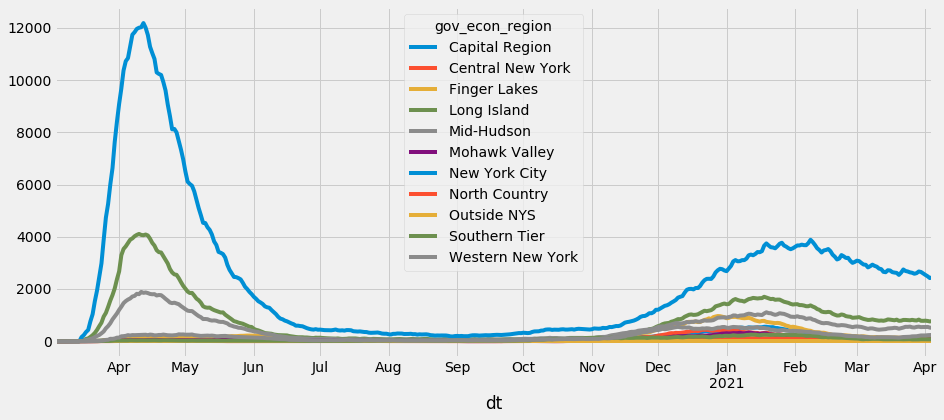

In [23]:
this_region_type='gov_econ_region'
df_nys.groupby(level=[this_region_type,'dt']
              ).sum()['Total hospitalizations_county'].unstack(this_region_type).plot(figsize=[14,6])
df_nys.groupby(level=[this_region_type,'dt']
              ).sum()['Total hospitalizations_county'].unstack(this_region_type).tail()


gov_econ_region,Capital Region,Central New York,Finger Lakes,Long Island,Mid-Hudson,Mohawk Valley,New York City,North Country,Southern Tier,Western New York
dt,,,,,,,,,,
2021-03-31,447.0,437.0,1412.0,1378.0,1589.0,292.0,4416.0,280.0,548.0,971.0
2021-04-01,450.0,480.0,1435.0,1472.0,1671.0,297.0,4479.0,275.0,566.0,976.0
2021-04-02,483.0,503.0,1456.0,1549.0,1672.0,326.0,4763.0,286.0,566.0,1065.0
2021-04-03,593.0,595.0,1530.0,1759.0,1926.0,352.0,5379.0,297.0,623.0,1266.0
2021-04-04,634.0,627.0,1562.0,1811.0,2012.0,341.0,5321.0,270.0,599.0,1296.0


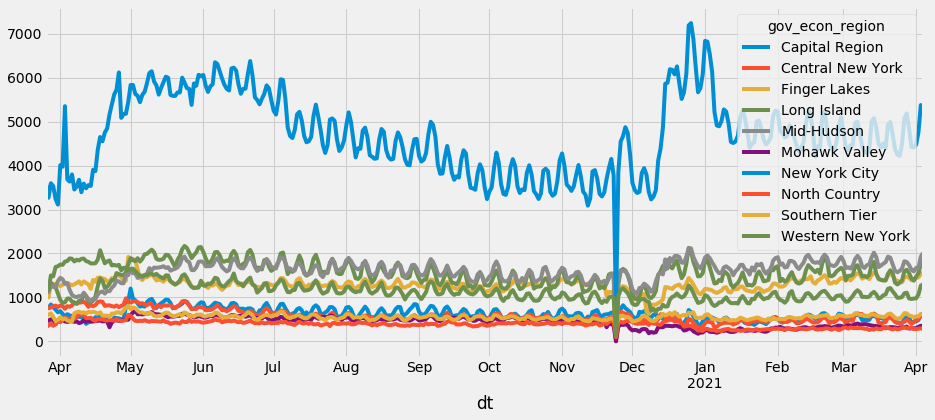

In [24]:
this_region_type='gov_econ_region'
metric = 'hosp_beds_avail'
df_nys[metric].dropna().groupby(level=[this_region_type,'dt']
              ).sum().unstack(this_region_type).dropna().plot(figsize=[14,6])
df_nys[metric].dropna().groupby(level=[this_region_type,'dt']
              ).sum().unstack(this_region_type).tail()


In [25]:
df_counties_4map = df_ny_mvmt[['dt','state','county','fips',this_region_type,'cases_per100k']].copy()
df_counties_4map.state = df_counties_4map[this_region_type]
df_counties_4map = df_counties_4map.set_index(['dt','state','county','fips'])
df_counties_4map.head()


,,,,gov_econ_region,cases_per100k
dt,state,county,fips,,
2020-02-15,Capital Region,Albany,36001,Capital Region,NaN
2020-02-16,Capital Region,Albany,36001,Capital Region,NaN
2020-02-17,Capital Region,Albany,36001,Capital Region,NaN
2020-02-18,Capital Region,Albany,36001,Capital Region,NaN
2020-02-19,Capital Region,Albany,36001,Capital Region,NaN


In [26]:
def make_model_dict_nys(region_name, df_ny_pop, df_nys, covid_params, d_to_forecast = 75,
                        df_mvmt=pd.DataFrame(), df_interventions=pd.DataFrame(), df_can=pd.DataFrame()):
    model_dict = {}

    model_dict['region_code'] = region_name
    model_dict['region_name'] = region_name
    model_dict['tot_pop'] = df_ny_pop

    model_dict['df_hist'] = pd.DataFrame()

    if df_nys['Cumulative hosp deaths_county'][model_dict['region_code']].dropna().shape[0] > 14:
        model_dict['df_hist']['deaths_tot'] = df_nys['Cumulative hosp deaths_county'][model_dict['region_code']]
#         if (model_dict['df_hist'].loc['2020-03-28', 'deaths_tot'] 
#             > model_dict['df_hist'].loc['2020-03-29', 'deaths_tot']):
        model_dict['df_hist'].loc['2020-03-28', 'deaths_tot'] = np.nan
        model_dict['df_hist']['deaths_tot'] = model_dict['df_hist']['deaths_tot'].interpolate()
        deaths_daily = model_dict['df_hist']['deaths_tot'].diff()
        model_dict['df_hist']['deaths_daily'] = deaths_daily.mask(deaths_daily < 0)

    if df_nys['Total hospitalizations_county'][model_dict['region_code']].dropna().shape[0] > 14:
        model_dict['df_hist']['hosp_concur'] = df_nys['Total hospitalizations_county'][model_dict['region_code']]

    if df_nys['Gross change total hosp_county'][model_dict['region_code']].dropna().shape[0] > 14:
        hosp_admits = df_nys['Gross change total hosp_county'][model_dict['region_code']]
        if hosp_admits.idxmax() == pd.Timestamp('2020-03-28'):
            hosp_admits.loc['2020-03-28':'2020-03-29'] = np.nan
        model_dict['df_hist']['hosp_admits'] = hosp_admits.mask(hosp_admits < 0)
            
    model_dict['df_hist']['cases_tot'] = df_nys['Positive tests_county'][model_dict['region_code']].cumsum()
    cases_daily = model_dict['df_hist']['cases_tot'].diff()
    model_dict['df_hist']['cases_daily'] = cases_daily.mask(cases_daily < 0)
    model_dict['df_hist']['pos_neg_tests_tot'] = df_nys['Daily tests_county'][model_dict['region_code']].cumsum()
    pos_neg_tests_daily = model_dict['df_hist']['pos_neg_tests_tot'].diff()
    model_dict['df_hist']['pos_neg_tests_daily'] = pos_neg_tests_daily.mask(pos_neg_tests_daily < 0)
    
    model_dict['df_hist']['hosp_beds_tot'] = df_nys['hosp_beds_tot'][model_dict['region_code']]
    model_dict['df_hist']['hosp_beds_avail'] = df_nys['hosp_beds_avail'][model_dict['region_code']]

    model_dict['covid_params'] = covid_params.copy()

#     if model_dict['df_hist']['deaths_daily'].mean() > 0.5:
#         # deaths_hosp_rat = np.linalg.lstsq(model_dict['df_hist'][['deaths_daily','hosp_concur']].dropna()['deaths_daily'].values.reshape(-1, 1),
#         #                                   model_dict['df_hist'][['deaths_daily','hosp_concur']].dropna()['hosp_concur'],
#         #                                   rcond=None)[0][0] / 9.0
#         deaths_shift = int(model_dict['covid_params']['d_incub'] + model_dict['covid_params']['d_til_death']) * -1
#         hosp_concur_shift = (int(model_dict['covid_params']['d_incub']
#                                  + model_dict['covid_params']['d_to_hosp']
#                                  + model_dict['covid_params']['d_in_hosp'] / 2)
#                              * -1)

#         df_dhratio = model_dict['df_hist'][['deaths_daily', 'hosp_concur']].copy()

#         df_dhratio['deaths_daily'] = df_dhratio['deaths_daily'].rolling(7).sum().shift(deaths_shift)
#         df_dhratio['hosp_concur'] = df_dhratio['hosp_concur'].rolling(7).mean().shift(hosp_concur_shift)
#         df_dhratio = df_dhratio.dropna()

#         deaths_hosp_rat = np.linalg.lstsq(df_dhratio['deaths_daily'].values.reshape(-1, 1),
#                                           df_dhratio['hosp_concur'], rcond=None)[0][0]

#         old_ratio = model_dict['covid_params']['hosp_rt'] / model_dict['covid_params']['mort_rt']
#         model_dict['covid_params']['hosp_rt'] = ((deaths_hosp_rat / old_ratio - 1) / 2 + 1) * model_dict['covid_params']['hosp_rt']
#         model_dict['covid_params']['mort_rt'] = model_dict['covid_params']['hosp_rt'] / deaths_hosp_rat
        
    model_dict = est_all_rts(model_dict)
    model_dict['df_rts'] = model_dict['df_rts_conf'].unstack().swaplevel(axis=1)['rt']
    model_dict['covid_params']['basic_r0'] = model_dict['df_rts']['weighted_average'].max()

    model_dict['d_to_forecast'] = int(d_to_forecast)
    
    model_dict['df_mvmt'] = df_mvmt
    model_dict['df_interventions'] = df_interventions
    model_dict['df_can'] = df_can
    model_dict['footnote_str'] = footnote_str_maker()
    model_dict['chart_title'] = ''

    return model_dict

In [27]:
covid_params = {}
covid_params['d_incub'] = 3.
covid_params['d_infect'] = 4.
covid_params['mort_rt'] = 0.01
covid_params['d_in_hosp'] = 11
covid_params['hosp_rt'] = 0.04
covid_params['d_to_hosp'] = 7.0
covid_params['d_in_hosp_mild'] = 11.0
covid_params['icu_rt'] = 13./41.
covid_params['d_in_icu'] = 13.0
covid_params['vent_rt'] = 0.4
covid_params['d_til_death'] =  17.0 ## Try 24.0 later
covid_params['policy_trigger'] = True
covid_params['policy_trigger_once'] = True
this_region_type = 'gov_econ_region'


In [27]:
df_nys.columns

Index(['Change in discharge_county', 'Chng hosp death_county_reported',
       'Cumulative discharge_county', 'Cumulative hosp deaths_county',
       'Daily tests_county', 'Gross change total hosp_county',
       'Net change ICU intubated_county', 'Net change total hosp_county',
       'New hosp death_county_occurred', 'New_hosp_admissions_county',
       'Positive tests_county', 'Total ICU intubated_county',
       'Total hospitalizations_county', 'hosp_beds_tot', 'hosp_beds_avail'],
      dtype='object')

In [120]:
df_cancounties.columns

Index(['date', 'country', 'state', 'county', 'fips', 'lat', 'long',
       'locationId', 'actuals.cases', 'actuals.deaths',
       'actuals.positiveTests', 'actuals.negativeTests',
       'actuals.contactTracers', 'actuals.hospitalBeds.capacity',
       'actuals.hospitalBeds.currentUsageTotal',
       'actuals.hospitalBeds.currentUsageCovid',
       'actuals.hospitalBeds.typicalUsageRate', 'actuals.icuBeds.capacity',
       'actuals.icuBeds.currentUsageTotal',
       'actuals.icuBeds.currentUsageCovid', 'actuals.icuBeds.typicalUsageRate',
       'actuals.newCases', 'actuals.vaccinesDistributed',
       'actuals.vaccinationsInitiated', 'actuals.vaccinationsCompleted',
       'metrics.testPositivityRatio', 'metrics.testPositivityRatioDetails',
       'metrics.caseDensity', 'metrics.contactTracerCapacityRatio',
       'metrics.infectionRate', 'metrics.infectionRateCI90',
       'metrics.icuHeadroomRatio', 'metrics.icuHeadroomDetails',
       'metrics.icuCapacityRatio', 'riskLevels.overall

In [28]:
region ='New York City'
model_dict = make_model_dict_nys(region, 
                                 df_ny_pop.groupby([this_region_type]).sum().loc[region, 'pop2019'], 
                                 df_nys.groupby(level=[this_region_type,'dt']).sum(), 
                                 covid_params, 200,
                                 df_mvmt=df_ny_mvmt.groupby([this_region_type,'dt']).mean().loc[region],
                                 df_interventions=df_interventions[
                                     df_interventions.region.isin(['Statewide (all)', region])],
                                 df_can=df_cancounties.groupby([this_region_type,'dt']).sum().loc[region]
                                )

df_interventions[df_interventions.region.isin(['Statewide (all)', model_dict['region_name']])]


deaths shifted by:  -20


,dt,region,event_name,Source Title,Source Link,social_distancing_direction
3,2020-03-07,Statewide (all),State of emergency declaration,NYS EO 202,https://www.governor.ny.gov/news/no-202-declar...,holiday
9,2020-03-18,Statewide (all),Schools closed,NYS EO 202.4,https://www.governor.ny.gov/news/no-2024-conti...,holiday
13,2020-03-22,Statewide (all),Closure of non-essential businesses,NYS EO 202.8,https://www.governor.ny.gov/news/no-2028-conti...,holiday
30,2020-06-08,New York City,Phase I re-opening (Construction and Manufactu...,NYS EO 202.31,https://www.governor.ny.gov/news/no-20231-cont...,holiday
40,2020-06-22,New York City,"Phase II re-opening (Professional services, Re...",NYS EO 202.35,https://www.governor.ny.gov/news/no-20235-cont...,holiday
50,2020-07-06,New York City,Phase III re-opening (Food services (NOT indoo...,NYS EO 202.41,https://www.governor.ny.gov/news/no-20241-cont...,holiday
53,2020-07-20,New York City,"Phase IV re-opening (Arts, entertainment and h...",NYS EO 202.45,https://www.governor.ny.gov/news/no-20245-cont...,holiday


In [29]:
model_dict['df_hist']['hosp_beds_avail'].tail()#.div(model_dict['df_hist']['pos_neg_tests_daily']).tail()

dt
2021-03-31    4416.0
2021-04-01    4479.0
2021-04-02    4763.0
2021-04-03    5379.0
2021-04-04    5321.0
Name: hosp_beds_avail, dtype: float64

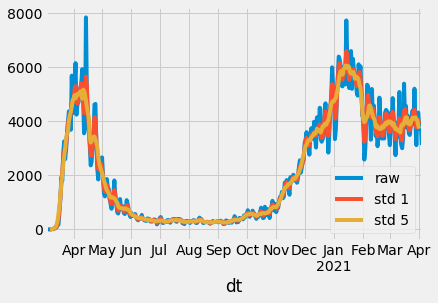

In [30]:
ax = model_dict['df_hist']['cases_daily'].plot(label='raw', legend=True)
model_dict['df_hist']['cases_daily'].rolling(7, win_type='gaussian', center=True).mean(std=1).plot(
    ax=ax, label='std 1', legend=True)
model_dict['df_hist']['cases_daily'].rolling(7, win_type='gaussian', center=True).mean(std=5).plot(
    ax=ax, label='std 5', legend=True)

In [32]:
if 'df_fore_allregions' in globals().keys():
    df_prevfore_allregions = df_fore_allregions.copy()
    
allregion_model_dicts = {}
df_rts_allregs = pd.DataFrame()
df_wavg_rt_conf_allregs = pd.DataFrame()
df_fore_allregions = pd.DataFrame()

nyreg_rep_order = ['Capital Region', 'Central New York', 'Finger Lakes', 'Mid-Hudson', 'Long Island',
 'Mohawk Valley', 'New York City', 'North Country', 'Southern Tier', 'Western New York']


for region in sorted(df_ny_pop[this_region_type].unique()):
    print(region)
    
    model_dict = make_model_dict_nys(region,
                                     df_ny_pop.groupby([this_region_type]).sum().loc[region, 'pop2019'], 
                                 df_nys.groupby(level=[this_region_type,'dt']).sum(), 
                                 covid_params, 200,
                                 df_mvmt=df_ny_mvmt.groupby([this_region_type,'dt']).mean().loc[region],
                                 df_interventions=df_interventions[
                                     df_interventions.region.isin(['Statewide (all)', region])],
                                    df_can=df_cancounties.groupby([this_region_type,'dt']).sum().loc[region])


    this_reg_df_rts = pd.DataFrame(model_dict['df_rts'].stack(), columns=[region])
    this_reg_df_wavg = pd.DataFrame(
        model_dict['df_rts_conf'].sort_index().unstack('metric')['weighted_average'].stack(), columns=[region])

    df_rts_allregs = pd.concat([df_rts_allregs, this_reg_df_rts], axis=1)
    df_wavg_rt_conf_allregs = pd.concat([df_wavg_rt_conf_allregs, this_reg_df_wavg], axis=1)

    try:
        first_guess = df_prevfore_allregions[region].first_valid_index()[0]
    except:
        first_guess = pd.Timestamp('2020-02-17')

    model_dict = model_find_start(first_guess, model_dict)
    df_agg = model_dict['df_agg']
    df_all_cohorts = model_dict['df_all_cohorts']

    print('Peak Hospitalization Date: ', df_agg.hospitalized.idxmax().strftime("%d %b, %Y"))
    print('Peak Hospitalization #: {:.0f}'.format(df_agg.hospitalized.max()))
    print('Peak ICU #: {:.0f}'.format(df_agg.icu.max()))
    print('Peak Ventilator #: {:.0f}'.format(df_agg.vent.max()))

    allregion_model_dicts[region] = model_dict
    df_fore_allregions = pd.concat([df_fore_allregions,pd.DataFrame(df_agg.stack(), columns=[region])], axis=1)

    model_dict['chart_title'] = r'No Change in Future $R_{t}$ Until Reaching Hospital Capacity Triggers Lockdown'

df_rts_allregs.index.names = ['dt','metric']

df_rt_report = df_wavg_rt_conf_allregs.dropna().unstack('metric').iloc[-1].unstack('metric')[
    ['rt','rt_l95','rt_u95']]

df_rt_report['rt'] = df_rt_report['rt'].apply(lambda x: '{:.2f}'.format(x))
df_rt_report['ci95'] = df_rt_report[['rt_l95','rt_u95']].apply(
    lambda x: '{:.2f} - {:.2f}'.format(x[0],x[1]), axis=1)
df_rt_report.loc[nyreg_rep_order, ['rt','ci95']].to_csv(
    './output/nys_fore/df_rts4nys_{}.csv'.format(pd.Timestamp.today().strftime("%Y%m%d")))

### Save Output ###
df_rts_allregs.index.names = ['dt','metric']

df_wavg_rt_conf_allregs.unstack('metric').to_csv(
    './output/nys_fore/df_wavg_rt_conf_allregs_{}.csv'.format(pd.Timestamp.today().strftime("%Y%m%d")),
    encoding='utf-8')
df_wavg_rt_conf_allregs.to_pickle('./output/nys_fore/df_wavg_rt_conf_allregs_{}.pkl'.format(
    pd.Timestamp.today().strftime("%Y%m%d")))

df_fore_allregions.unstack('metric').to_csv(
    './output/nys_fore/df_fore_allregions_{}.csv'.format(pd.Timestamp.today().strftime("%Y%m%d")),
    encoding='utf-8')
df_fore_allregions.to_pickle('./output/nys_fore/df_fore_allregions_{}.pkl'.format(pd.Timestamp.today().strftime("%Y%m%d")))

asmd_filename = './output/nys_fore/allregion_model_dicts_{}.pkl'.format(pd.Timestamp.today().strftime("%Y%m%d"))

with open(asmd_filename, 'wb') as handle:
    pickle.dump(allregion_model_dicts, handle, protocol=pickle.HIGHEST_PROTOCOL)

display(df_rt_report.loc[nyreg_rep_order, ['rt','ci95']])


Capital Region
deaths shifted by:  -20
This guess:  2020-02-29 00:00:00
This rmse:  284.3147045114929
Change in rmse:  -1
Average Error:  -5.305452975495773
This guess:  2020-03-01 00:00:00
This rmse:  313.67725663525835
Change in rmse:  29.362552123765454
Average Error:  28.28239671746269
Best starting date:  2020-02-29 00:00:00
Peak Hospitalization Date:  16 Jan, 2021
Peak Hospitalization #: 368
Peak ICU #: 117
Peak Ventilator #: 47
Central New York
deaths shifted by:  -20
This guess:  2020-03-12 00:00:00
This rmse:  311.9098747449429
Change in rmse:  -1
Average Error:  16.38052268385615
This guess:  2020-03-11 00:00:00
This rmse:  293.6957224917814
Change in rmse:  -18.2141522531615
Average Error:  -1.1523840648245762
This guess:  2020-03-12 00:00:00
This rmse:  311.9098747449429
Change in rmse:  18.2141522531615
Average Error:  16.38052268385615
Best starting date:  2020-03-11 00:00:00
Peak Hospitalization Date:  12 Aug, 2021
Peak Hospitalization #: 569
Peak ICU #: 187
Peak Ventila

metric,rt,ci95
Capital Region,1.02,0.79 - 1.25
Central New York,1.15,0.84 - 1.46
Finger Lakes,1.14,0.81 - 1.46
Mid-Hudson,0.99,0.84 - 1.14
Long Island,1.01,0.80 - 1.21
Mohawk Valley,1.00,0.74 - 1.26
New York City,0.99,0.82 - 1.16
North Country,1.12,0.76 - 1.48
Southern Tier,1.09,0.86 - 1.32
Western New York,1.31,1.01 - 1.60


In [31]:
# df_wavg_rt_conf_allregs = pd.read_pickle('./output/nys_fore/df_wavg_rt_conf_allregs_{}.pkl'.format(
#     pd.Timestamp.today().strftime("%Y%m%d")))
# df_fore_allregions = pd.read_pickle('./output/nys_fore/df_fore_allregions_{}.pkl'.format(
#     pd.Timestamp.today().strftime("%Y%m%d")))

# asmd_filename = './output/nys_fore/allregion_model_dicts_{}.pkl'.format(pd.Timestamp.today().strftime("%Y%m%d"))

# with open(asmd_filename, 'wb') as handle:
#     pickle.dump(allregion_model_dicts, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [165]:
# region = 'New York City'
# covid_params['d_til_death'] = 24.0
# model_dict = make_model_dict_nys(region,
#                                  df_ny_pop.groupby([this_region_type]).sum().loc[region, 'pop2019'], 
#                              df_nys.groupby(level=[this_region_type,'dt']).sum(), 
#                              covid_params, 200,
#                              df_mvmt=df_ny_mvmt.groupby([this_region_type,'dt']).mean().loc[region],
#                              df_interventions=df_interventions[
#                                  df_interventions.region.isin(['Statewide (all)', region])])

# this_reg_df_rts = pd.DataFrame(model_dict['df_rts'].stack(), columns=[region])
# this_reg_df_wavg = pd.DataFrame(
#     model_dict['df_rts_conf'].sort_index().unstack('metric')['weighted_average'].stack(), columns=[region])

# df_rts_allregs = pd.concat([df_rts_allregs, this_reg_df_rts], axis=1)
# df_wavg_rt_conf_allregs = pd.concat([df_wavg_rt_conf_allregs, this_reg_df_wavg], axis=1)

# try:
#     first_guess = df_prevfore_allregions[region].first_valid_index()[0]
# except:
#     first_guess = pd.Timestamp('2020-02-17')

# model_dict = model_find_start(pd.Timestamp('2020-01-16'), model_dict)
# model_dict['chart_title'] =    ''

In [166]:
# model_dict['chart_title'] =    ''
# ax = ch_rts(model_dict); plt.show()
# ax = ch_deaths_tot(model_dict); plt.show()
# ax = ch_daily_deaths(model_dict); plt.show()
# ax = ch_hosp_concur(model_dict); plt.show()
# ax = ch_hosp_admits(model_dict); plt.show()
# ax = ch_exposed_infectious(model_dict); plt.show()


In [167]:
# hosp_beds_avail = model_dict['df_hist']['hosp_beds_avail']
# first_nonzero_idx = hosp_beds_avail.to_numpy().nonzero()[0][0]


# total_beds4covid = model_dict['df_hist']['hosp_concur'].add(
#     hosp_beds_avail.iloc[first_nonzero_idx:]).rolling(7).mean()
# total_beds4covid.fillna(method='ffill').fillna(method='bfill').plot()
# model_dict['df_hist']['hosp_concur'].plot()
# hosp_beds_avail.iloc[first_nonzero_idx:].plot()


In [168]:
# fig = ch_rt_summary(df_wavg_rt_conf_allregs)
# fig = add_plotly_footnote(fig)
# fig.write_html('./output/nys_fore/rt_summary.html', include_plotlyjs='cdn')

# fig = ch_exposure_prob(df_fore_allregions,
#                        df_census[df_census.SUMLEV == 40].set_index('state')['pop2019'])
# fig = add_plotly_footnote(fig)
# fig.write_html('./output/state_fore/ch_exposure_prob.html', include_plotlyjs='cdn')
# fig.write_html('../donnellymjd.github.io/_covid19/datacenter/plotly/ch_exposure_prob.html', include_plotlyjs='cdn')


In [169]:
# covid_hosp_capacity = model_dict['df_hist']['hosp_beds_avail'].replace(0,np.nan).dropna()
# covid_hosp_capacity = covid_hosp_capacity + model_dict['df_hist']['hosp_concur'].dropna()
# covid_hosp_capacity = covid_hosp_capacity.rolling(7).mean()
# covid_hosp_capacity.plot(); plt.show()
# normal_capacity = covid_hosp_capacity.quantile(.05)

# Scenarios

In [54]:
print([key for key in allregion_model_dicts[region].keys() if key[:11] != 'model_dict_'])

['region_code', 'region_name', 'tot_pop', 'df_hist', 'covid_params', 'df_rts_conf', 'df_hist_shifted', 'df_lambdas', 'df_rts', 'd_to_forecast', 'df_mvmt', 'df_interventions', 'footnote_str', 'chart_title', 'hosp_cap_dt', 'df_agg', 'df_all_cohorts', 'rmses']


In [55]:
l_scen_md_copy = [key for key in allregion_model_dicts[region].keys() if key[:11] != 'model_dict_']
l_scen_md_deepcopy = ['covid_params', 'df_rts_conf', 'df_lambdas', 'df_rts', 'd_to_forecast', 
                      'footnote_str', 'chart_title', 'hosp_cap_dt', 'df_agg', 'df_all_cohorts', 'rmses']

In [172]:
# ########### VOC SCENARIO 1 ##########
# scenname = 'model_dict_scen_htvariant1'
# ht_variant_pct_more_transmissible = 0.7
# ht_variant_prev_curr = 1/100
# ht_variant_prev_3m = 0.75
# tspan = np.arange(0, 365, 1)

# # Calculate Prevalence forecast
# ht_variant_prev_t = ( (ht_variant_prev_curr - ht_variant_prev_3m)
#                     / (1 + np.exp(0.1 * (tspan - 45) ) )
#                     + ht_variant_prev_3m)
# ht_variant_prev_idx = pd.date_range(start = (pd.Timestamp('2021-01-01')), 
#                             periods = 365, 
#                             freq = '1D')
# ht_variant_prev_t = pd.Series(ht_variant_prev_t, index = ht_variant_prev_idx)
# ht_variant_prev_t.plot(title='ht_variant_prev_t')
# plt.show()

# test = model_dict['df_rts'].loc[:,'rt_scenario']
# test = test.mul(ht_variant_prev_t * ht_variant_pct_more_transmissible + 1)
# ax = test.plot()
# model_dict['df_rts'].loc[:,'rt_scenario'].plot()
# plt.show()

# import copy

# df_scen_htvariant1_fore_allregions = pd.DataFrame()

# for region in sorted(df_ny_pop[this_region_type].unique()):
#     print(region)
#     model_dict = allregion_model_dicts[region]
#     if scenname in model_dict.keys():
#         del model_dict[scenname]
# #     model_dict[scenname] = copy.deepcopy(model_dict)
#     model_dict[scenname] = dict((k, model_dict[k]) for k in l_scen_md_copy if k in model_dict)
#     for key in l_scen_md_deepcopy:
#         model_dict[scenname][key] = copy.deepcopy(model_dict[key])
    
#     r_t = model_dict['df_rts']['weighted_average'].copy()
#     local_r0_date = r_t.loc['2020-02-01':'2020-04-30'].idxmax()
#     voc_multiplier = ht_variant_prev_t.loc[r_t.last_valid_index():] * ht_variant_pct_more_transmissible + 1
#     r_t = r_t.loc[local_r0_date:].fillna(method='ffill').mul(voc_multiplier).fillna(r_t)
#     model_dict[scenname]['df_rts']['rt_scenario'] = r_t

#     start_date = model_dict['df_agg'].first_valid_index() - pd.Timedelta(days=1)
#     exposed_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)
#     infectious_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)

#     model_dict[scenname] = seir_model_cohort(start_date, model_dict[scenname], 
#                                                        exposed_0, infectious_0)
#     model_dict[scenname]['chart_title'] = \
#         f'Highly Transmissible Variants {ht_variant_pct_more_transmissible:.0%} more transmissible, Reaching Hospital Capacity Triggers Lockdown'
#     allregion_model_dicts[region] = model_dict
#     df_scen_htvariant1_fore_allregions = pd.concat([df_scen_htvariant1_fore_allregions,
#                                           pd.DataFrame(
#                                               model_dict[scenname]['df_agg'].stack(), 
#                                               columns=[region])], 
#                                          axis=1)



In [173]:
# # ########## VOC SCENARIO 2 ##########
# scenname = 'model_dict_scen_htvariant2'
# ht_variant_pct_more_transmissible = 0.35
# ht_variant_prev_curr = 1/100
# ht_variant_prev_3m = 0.75
# tspan = np.arange(0, 365, 1)

# # Calculate Prevalence forecast
# ht_variant_prev_t = ( (ht_variant_prev_curr - ht_variant_prev_3m)
#                     / (1 + np.exp(0.1 * (tspan - 45) ) )
#                     + ht_variant_prev_3m)
# ht_variant_prev_idx = pd.date_range(start = (pd.Timestamp('2021-01-01')), 
#                             periods = 365, 
#                             freq = '1D')
# ht_variant_prev_t = pd.Series(ht_variant_prev_t, index = ht_variant_prev_idx)
# ht_variant_prev_t.plot(title='ht_variant_prev_t')
# plt.show()

# test = model_dict['df_rts'].loc[:,'rt_scenario']
# test = test.mul(ht_variant_prev_t * ht_variant_pct_more_transmissible + 1)
# ax = test.plot()
# model_dict['df_rts'].loc[:,'rt_scenario'].plot()
# plt.show()

# import copy

# df_scen_htvariant2_fore_allregions = pd.DataFrame()

# for region in sorted(df_ny_pop[this_region_type].unique()):
#     print(region)
#     model_dict = allregion_model_dicts[region]
#     if scenname in model_dict.keys():
#         del model_dict[scenname]
# #     model_dict[scenname] = copy.deepcopy(model_dict)
#     model_dict[scenname] = dict((k, model_dict[k]) for k in l_scen_md_copy if k in model_dict)
#     for key in l_scen_md_deepcopy:
#         model_dict[scenname][key] = copy.deepcopy(model_dict[key])
    
#     r_t = model_dict['df_rts']['weighted_average'].copy()
#     local_r0_date = r_t.loc['2020-02-01':'2020-04-30'].idxmax()
#     voc_multiplier = ht_variant_prev_t.loc[r_t.last_valid_index():] * ht_variant_pct_more_transmissible + 1
#     r_t = r_t.loc[local_r0_date:].fillna(method='ffill').mul(voc_multiplier).fillna(r_t)
#     model_dict[scenname]['df_rts']['rt_scenario'] = r_t

#     start_date = model_dict['df_agg'].first_valid_index() - pd.Timedelta(days=1)
#     exposed_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)
#     infectious_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)

#     model_dict[scenname] = seir_model_cohort(start_date, model_dict[scenname], 
#                                                        exposed_0, infectious_0)
#     model_dict[scenname]['chart_title'] = \
#         f'Highly Transmissible Variants {ht_variant_pct_more_transmissible:.0%} more transmissible, Reaching Hospital Capacity Triggers Lockdown'
#     allregion_model_dicts[region] = model_dict
#     df_scen_htvariant2_fore_allregions = pd.concat([df_scen_htvariant2_fore_allregions,
#                                           pd.DataFrame(
#                                               model_dict[scenname]['df_agg'].stack(), 
#                                               columns=[region])], 
#                                          axis=1)



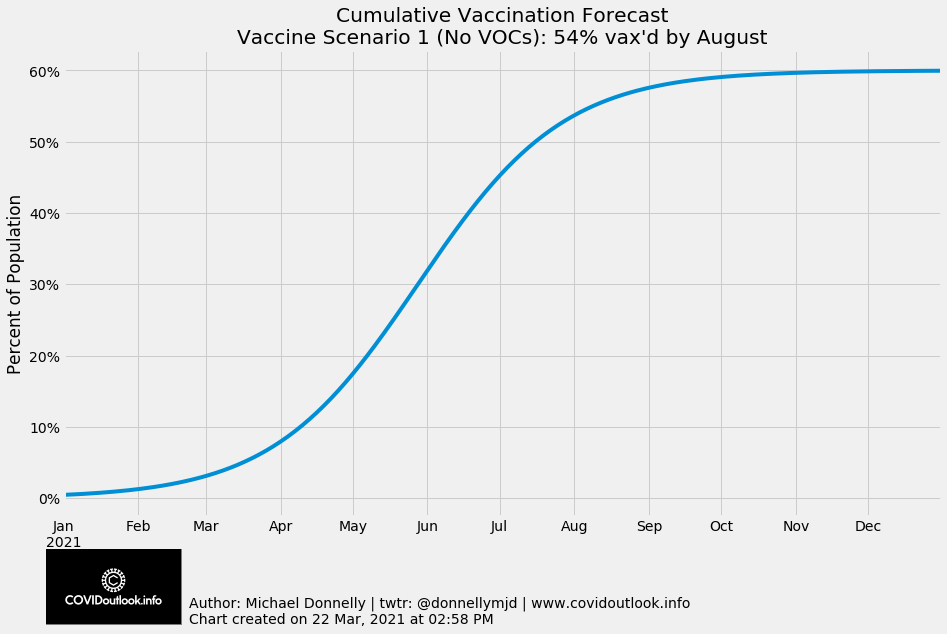

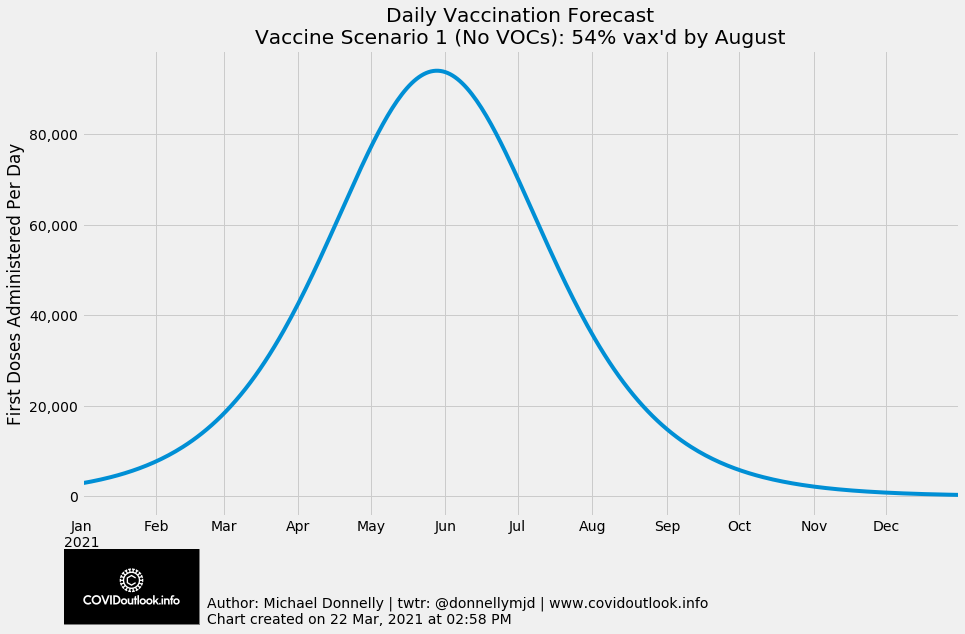

Capital Region
Central New York
Finger Lakes
Long Island
Mid-Hudson
Mohawk Valley
New York City
North Country
Southern Tier
Western New York


In [183]:
# # ########## Vaccine SCENARIO 1 ##########
# scenname = 'model_dict_scen_vaccine1'
# # https://covid19vaccine.health.ny.gov/covid-19-vaccine-tracker
# # https://covid.cdc.gov/covid-data-tracker/#vaccinations
# vaccine_effectiveness = 0.94
# vaccine_prop_max = 0.6
# speed_of_rollout = 0.033
# curr_vaxxed = 1.1e6
# totpop = 19e6

# vaccine_prop_curr = 0 
# tspan = np.arange(0, 365*3, 1)

# # Calculate Prevalence forecast

# vaccine_prop_t = ( (vaccine_prop_curr - (vaccine_prop_max) )
#                     / (1 + np.exp(speed_of_rollout * (tspan - 500) ) )
#                     + vaccine_prop_max)
# vaccine_prop_t = pd.Series(vaccine_prop_t)
# curr_vax_idx = vaccine_prop_t[vaccine_prop_t >= curr_vaxxed / totpop].first_valid_index()
# today_idx = (pd.Timestamp.today() - pd.Timestamp('2020-01-01')).days
# vaccine_prop_idx = pd.date_range(start = (pd.Timestamp('2020-01-01')), 
#                             periods = 365*3, 
#                             freq = '1D')
# vaccine_prop_t.index = vaccine_prop_idx
# vaccine_prop_t = vaccine_prop_t.shift(today_idx - curr_vax_idx).fillna(method='ffill').fillna(method='bfill')
# dt_vax_90p_done = vaccine_prop_t[vaccine_prop_t >= vaccine_prop_max * .9].first_valid_index()

# this_scenario_title = f'Vaccine Scenario 1 (No VOCs): {vaccine_prop_max * .9:.0%} vax\'d by {dt_vax_90p_done.strftime("%B")}'

# ax = vaccine_prop_t.loc['2021-01-01':'2021-12-31'].plot(figsize=[14, 8], title = 'Cumulative Vaccination Forecast\n'+this_scenario_title)
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# ax.set_xlabel('')
# ax.set_ylabel('Percent of Population')
# ax = add_logo(ax)
# plt.annotate(model_dict['footnote_str'],
#              (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')

# plt.show()
# ax = vaccine_prop_t.mul(totpop).diff().loc['2021-01-01':'2021-12-31'].plot(figsize=[14, 8], title = 'Daily Vaccination Forecast\n'+this_scenario_title)
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax.set_xlabel('')
# ax.set_ylabel('First Doses Administered Per Day')
# ax = add_logo(ax)
# plt.annotate(model_dict['footnote_str'],
#              (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')
# plt.show()

# import copy

# df_scen_vaccine1_fore_allregions = pd.DataFrame()

# for region in sorted(df_ny_pop[this_region_type].unique()):
#     print(region)
#     model_dict = allregion_model_dicts[region]
#     if scenname in model_dict.keys():
#         del model_dict[scenname]
# #     model_dict[scenname] = copy.deepcopy(model_dict)
#     model_dict[scenname] = dict((k, model_dict[k]) for k in l_scen_md_copy if k in model_dict)
#     for key in l_scen_md_deepcopy:
#         model_dict[scenname][key] = copy.deepcopy(model_dict[key])
    
#     model_dict[scenname]['vaccine_prop_t'] = vaccine_prop_t * vaccine_effectiveness

#     start_date = model_dict['df_agg'].first_valid_index() - pd.Timedelta(days=1)
#     exposed_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)
#     infectious_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)

#     model_dict[scenname] = seir_model_cohort(start_date, model_dict[scenname], 
#                                                        exposed_0, infectious_0)
#     model_dict[scenname]['chart_title'] = this_scenario_title
#     allregion_model_dicts[region] = model_dict
#     df_scen_vaccine1_fore_allregions = pd.concat([df_scen_vaccine1_fore_allregions,
#                                           pd.DataFrame(
#                                               model_dict[scenname]['df_agg'].stack(), 
#                                               columns=[region])], 
#                                          axis=1)


In [184]:
# # ########## Vaccine SCENARIO 2 ##########
# scenname = 'model_dict_scen_vaccine2'
# # https://covid19vaccine.health.ny.gov/covid-19-vaccine-tracker
# # https://covid.cdc.gov/covid-data-tracker/#vaccinations
# vaccine_effectiveness = 0.94
# vaccine_prop_max = 0.6
# speed_of_rollout = 0.015
# curr_vaxxed = 1.1e6
# totpop = 19e6

# vaccine_prop_curr = 0 
# tspan = np.arange(0, 365*3, 1)

# # Calculate Prevalence forecast

# vaccine_prop_t = ( (vaccine_prop_curr - (vaccine_prop_max) )
#                     / (1 + np.exp(speed_of_rollout * (tspan - 500) ) )
#                     + vaccine_prop_max)
# vaccine_prop_t = pd.Series(vaccine_prop_t)
# curr_vax_idx = vaccine_prop_t[vaccine_prop_t >= curr_vaxxed / totpop].first_valid_index()
# today_idx = (pd.Timestamp.today() - pd.Timestamp('2020-01-01')).days
# vaccine_prop_idx = pd.date_range(start = (pd.Timestamp('2020-01-01')), 
#                             periods = 365*3, 
#                             freq = '1D')
# vaccine_prop_t.index = vaccine_prop_idx
# vaccine_prop_t = vaccine_prop_t.shift(today_idx - curr_vax_idx).fillna(method='ffill').fillna(method='bfill')
# dt_vax_90p_done = vaccine_prop_t[vaccine_prop_t >= vaccine_prop_max * .9].first_valid_index()

# this_scenario_title = f'Vaccine Scenario 2 (No VOCs): {vaccine_prop_max * .9:.0%} vax\'d by {dt_vax_90p_done.strftime("%B")}'

# ax = vaccine_prop_t.loc['2021-01-01':'2021-12-31'].plot(figsize=[14, 8], title = 'Cumulative Vaccination Forecast\n'+this_scenario_title)
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# ax.set_xlabel('')
# ax.set_ylabel('Percent of Population')
# ax = add_logo(ax)
# plt.annotate(model_dict['footnote_str'],
#              (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')

# plt.show()
# ax = vaccine_prop_t.mul(totpop).diff().loc['2021-01-01':'2021-12-31'].plot(figsize=[14, 8], title = 'Daily Vaccination Forecast\n'+this_scenario_title)
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax.set_xlabel('')
# ax.set_ylabel('First Doses Administered Per Day')
# ax = add_logo(ax)
# plt.annotate(model_dict['footnote_str'],
#              (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')
# plt.show()

# import copy

# df_scen_vaccine2_fore_allregions = pd.DataFrame()

# for region in sorted(df_ny_pop[this_region_type].unique()):
#     print(region)
#     model_dict = allregion_model_dicts[region]
#     if scenname in model_dict.keys():
#         del model_dict[scenname]
# #     model_dict[scenname] = copy.deepcopy(model_dict)
#     model_dict[scenname] = dict((k, model_dict[k]) for k in l_scen_md_copy if k in model_dict)
#     for key in l_scen_md_deepcopy:
#         model_dict[scenname][key] = copy.deepcopy(model_dict[key])
    
#     model_dict[scenname]['vaccine_prop_t'] = vaccine_prop_t * vaccine_effectiveness

#     start_date = model_dict['df_agg'].first_valid_index() - pd.Timedelta(days=1)
#     exposed_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)
#     infectious_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)

#     model_dict[scenname] = seir_model_cohort(start_date, model_dict[scenname], 
#                                                        exposed_0, infectious_0)
#     model_dict[scenname]['chart_title'] = this_scenario_title
#     allregion_model_dicts[region] = model_dict
#     df_scen_vaccine2_fore_allregions = pd.concat([df_scen_vaccine2_fore_allregions,
#                                           pd.DataFrame(
#                                               model_dict[scenname]['df_agg'].stack(), 
#                                               columns=[region])], 
#                                          axis=1)


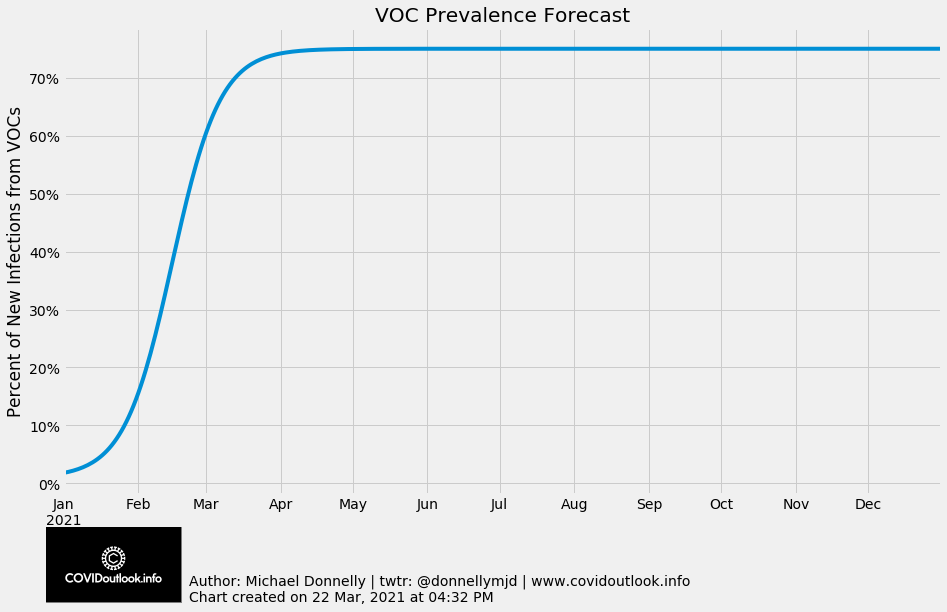

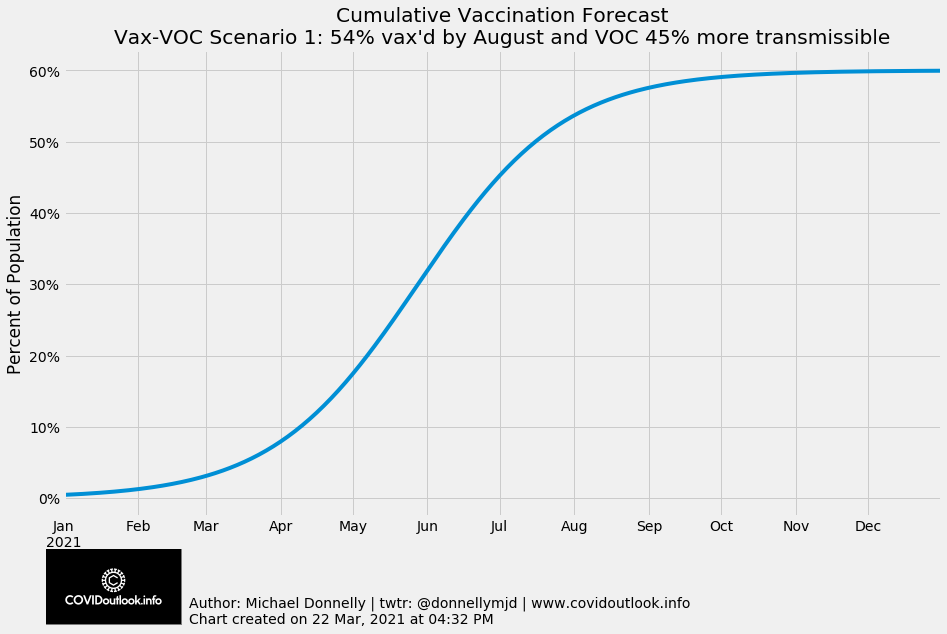

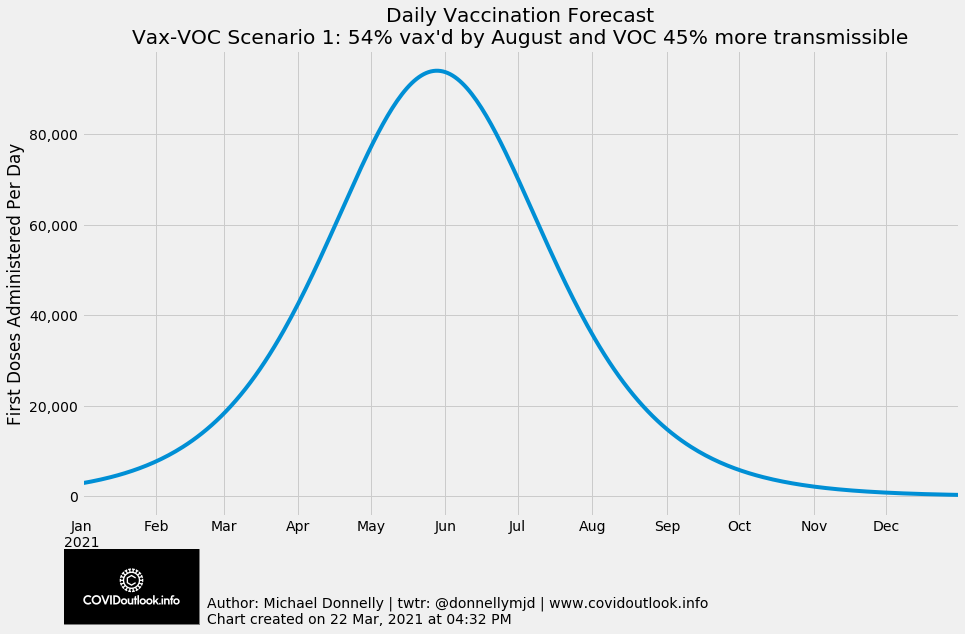

Capital Region
Central New York
Finger Lakes
Long Island
Mid-Hudson
Mohawk Valley
New York City
North Country
Southern Tier
Western New York


In [185]:
# # ########## Vax-VOC Scenario 1 ##########
# scenname = 'model_dict_scen_vaxvoc1'
# ht_variant_pct_more_transmissible = 0.45
# ht_variant_prev_curr = 1/100
# ht_variant_prev_3m = 0.75
# tspan = np.arange(0, 365, 1)

# # Calculate Prevalence forecast
# ht_variant_prev_t = ( (ht_variant_prev_curr - ht_variant_prev_3m)
#                     / (1 + np.exp(0.1 * (tspan - 45) ) )
#                     + ht_variant_prev_3m)
# ht_variant_prev_idx = pd.date_range(start = (pd.Timestamp('2021-01-01')), 
#                             periods = 365, 
#                             freq = '1D')
# ht_variant_prev_t = pd.Series(ht_variant_prev_t, index = ht_variant_prev_idx)
# ax = ht_variant_prev_t.plot(figsize=[14, 8], title = 'VOC Prevalence Forecast')
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# ax.set_xlabel('')
# ax.set_ylabel('Percent of New Infections from VOCs')
# ax = add_logo(ax)
# plt.annotate(footnote_str_maker(),
#              (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')
# plt.show()

# # https://covid19vaccine.health.ny.gov/covid-19-vaccine-tracker
# # https://covid.cdc.gov/covid-data-tracker/#vaccinations
# vaccine_effectiveness = 0.94
# vaccine_prop_max = 0.6
# speed_of_rollout = 0.033
# curr_vaxxed = 1.1e6
# totpop = 19e6

# vaccine_prop_curr = 0 
# tspan = np.arange(0, 365*3, 1)

# # Calculate Prevalence forecast

# vaccine_prop_t = ( (vaccine_prop_curr - (vaccine_prop_max) )
#                     / (1 + np.exp(speed_of_rollout * (tspan - 500) ) )
#                     + vaccine_prop_max)
# vaccine_prop_t = pd.Series(vaccine_prop_t)
# curr_vax_idx = vaccine_prop_t[vaccine_prop_t >= curr_vaxxed / totpop].first_valid_index()
# today_idx = (pd.Timestamp.today() - pd.Timestamp('2020-01-01')).days
# vaccine_prop_idx = pd.date_range(start = (pd.Timestamp('2020-01-01')), 
#                             periods = 365*3, 
#                             freq = '1D')
# vaccine_prop_t.index = vaccine_prop_idx
# vaccine_prop_t = vaccine_prop_t.shift(today_idx - curr_vax_idx).fillna(method='ffill').fillna(method='bfill')
# dt_vax_90p_done = vaccine_prop_t[vaccine_prop_t >= vaccine_prop_max * .9].first_valid_index()

# this_scenario_title = f'Vax-VOC Scenario 1: {vaccine_prop_max* .9:.0%} vax\'d by {dt_vax_90p_done.strftime("%B")} and VOC {ht_variant_pct_more_transmissible:.0%} more transmissible'

# ax = vaccine_prop_t.loc['2021-01-01':'2021-12-31'].plot(figsize=[14, 8], title = 'Cumulative Vaccination Forecast\n'+this_scenario_title)
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# ax.set_xlabel('')
# ax.set_ylabel('Percent of Population')
# ax = add_logo(ax)
# plt.annotate(footnote_str_maker(),
#              (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')

# plt.show()
# ax = vaccine_prop_t.mul(totpop).diff().loc['2021-01-01':'2021-12-31'].plot(figsize=[14, 8], title = 'Daily Vaccination Forecast\n'+this_scenario_title)
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax.set_xlabel('')
# ax.set_ylabel('First Doses Administered Per Day')
# ax = add_logo(ax)
# plt.annotate(footnote_str_maker(),
#              (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')
# plt.show()

# import copy

# df_scen_vaxvoc1_fore_allregions = pd.DataFrame()

# for region in sorted(df_ny_pop[this_region_type].unique()):
#     print(region)
#     model_dict = allregion_model_dicts[region]
#     if scenname in model_dict.keys():
#         del model_dict[scenname]
# #     model_dict[scenname] = copy.deepcopy(model_dict)
#     model_dict[scenname] = dict((k, model_dict[k]) for k in l_scen_md_copy if k in model_dict)
#     for key in l_scen_md_deepcopy:
#         model_dict[scenname][key] = copy.deepcopy(model_dict[key])
    
#     model_dict[scenname]['vaccine_prop_t'] = vaccine_prop_t * vaccine_effectiveness
    
#     r_t = model_dict['df_rts']['weighted_average'].copy()
#     local_r0_date = r_t.loc['2020-02-01':'2020-04-30'].idxmax()
#     voc_multiplier = ht_variant_prev_t.loc[r_t.last_valid_index():] * ht_variant_pct_more_transmissible + 1
#     r_t = r_t.loc[local_r0_date:].fillna(method='ffill').mul(voc_multiplier).fillna(r_t)
#     model_dict[scenname]['df_rts']['rt_scenario'] = r_t

#     start_date = model_dict['df_agg'].first_valid_index() - pd.Timedelta(days=1)
#     exposed_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)
#     infectious_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)

#     model_dict[scenname] = seir_model_cohort(start_date, model_dict[scenname], 
#                                                        exposed_0, infectious_0)
#     model_dict[scenname]['chart_title'] = this_scenario_title
#     allregion_model_dicts[region] = model_dict
#     df_scen_vaxvoc1_fore_allregions = pd.concat([df_scen_vaxvoc1_fore_allregions,
#                                           pd.DataFrame(
#                                               model_dict[scenname]['df_agg'].stack(), 
#                                               columns=[region])], 
#                                          axis=1)



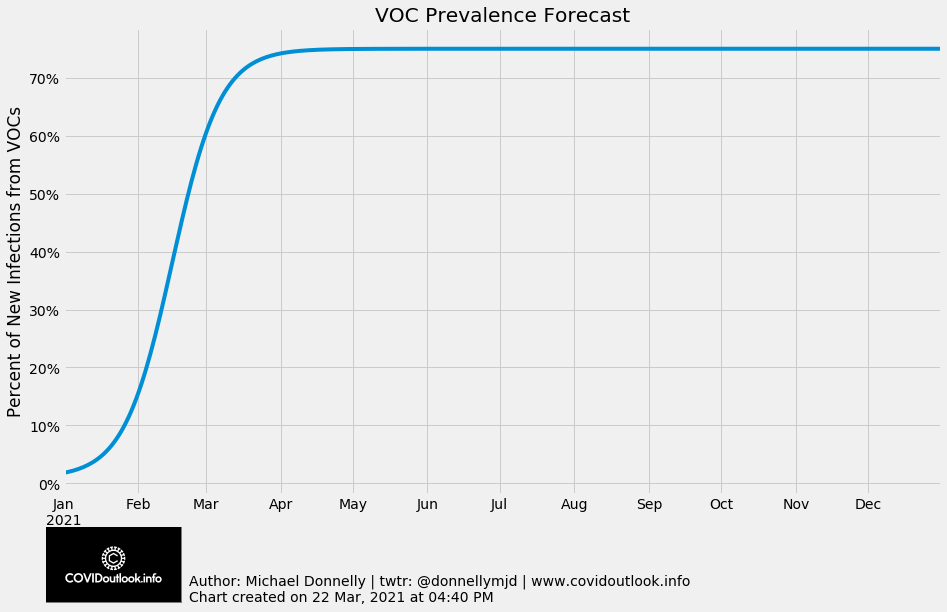

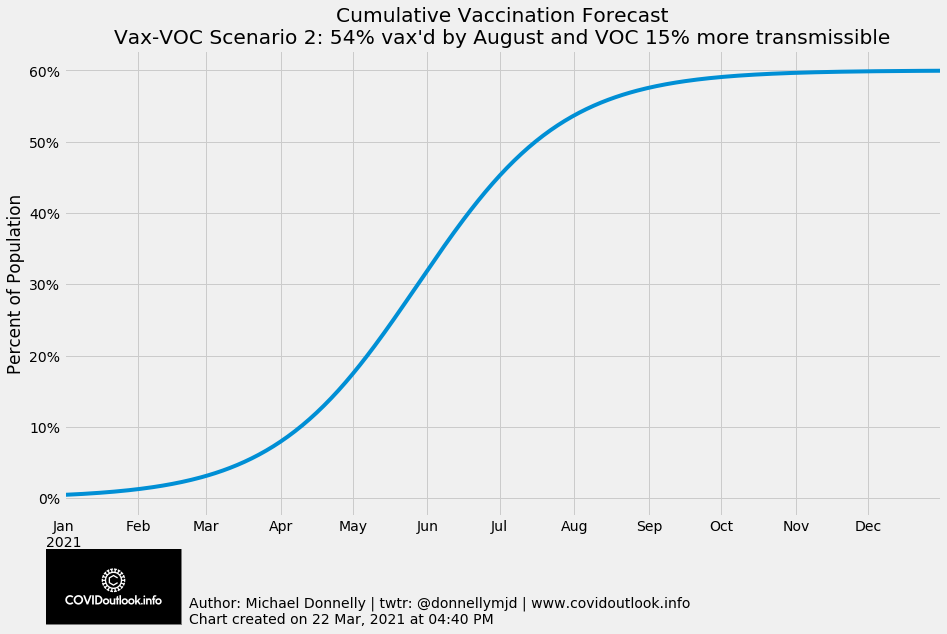

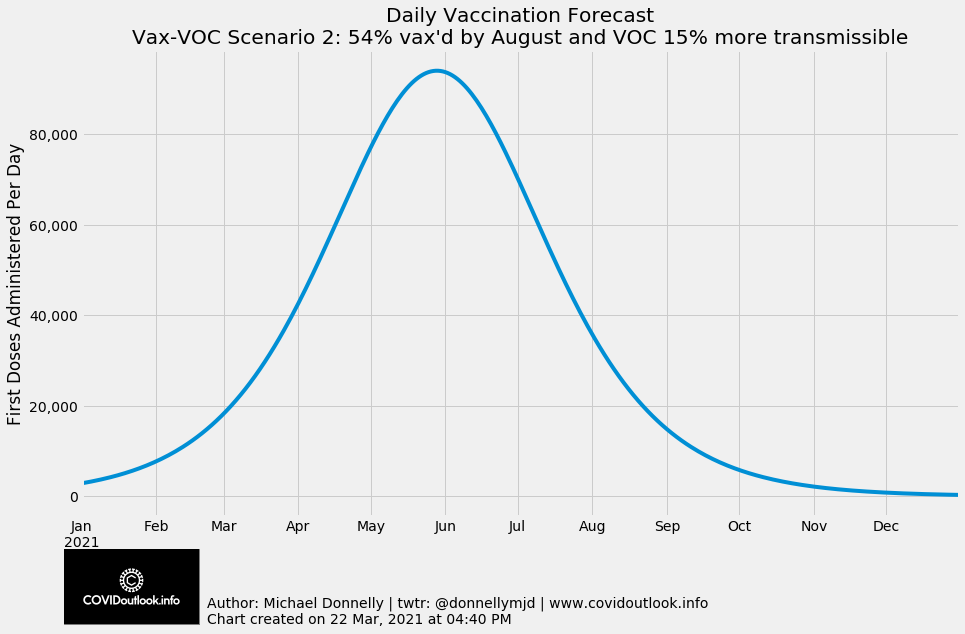

Capital Region
Central New York
Finger Lakes
Long Island
Mid-Hudson
Mohawk Valley
New York City
North Country
Southern Tier
Western New York


In [186]:
# # ########## Vax-VOC Scenario 2 ##########
# scenname = 'model_dict_scen_vaxvoc2'
# ht_variant_pct_more_transmissible = 0.15
# ht_variant_prev_curr = 1/100
# ht_variant_prev_3m = 0.75
# tspan = np.arange(0, 365, 1)

# # Calculate Prevalence forecast
# ht_variant_prev_t = ( (ht_variant_prev_curr - ht_variant_prev_3m)
#                     / (1 + np.exp(0.1 * (tspan - 45) ) )
#                     + ht_variant_prev_3m)
# ht_variant_prev_idx = pd.date_range(start = (pd.Timestamp('2021-01-01')), 
#                             periods = 365, 
#                             freq = '1D')
# ht_variant_prev_t = pd.Series(ht_variant_prev_t, index = ht_variant_prev_idx)
# ax = ht_variant_prev_t.plot(figsize=[14, 8], title = 'VOC Prevalence Forecast')
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# ax.set_xlabel('')
# ax.set_ylabel('Percent of New Infections from VOCs')
# ax = add_logo(ax)
# plt.annotate(footnote_str_maker(),
#              (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')
# plt.show()

# # https://covid19vaccine.health.ny.gov/covid-19-vaccine-tracker
# # https://covid.cdc.gov/covid-data-tracker/#vaccinations
# vaccine_effectiveness = 0.94
# vaccine_prop_max = 0.6
# speed_of_rollout = 0.033
# curr_vaxxed = 1.1e6
# totpop = 19e6

# vaccine_prop_curr = 0 
# tspan = np.arange(0, 365*3, 1)

# # Calculate Prevalence forecast

# vaccine_prop_t = ( (vaccine_prop_curr - (vaccine_prop_max) )
#                     / (1 + np.exp(speed_of_rollout * (tspan - 500) ) )
#                     + vaccine_prop_max)
# vaccine_prop_t = pd.Series(vaccine_prop_t)
# curr_vax_idx = vaccine_prop_t[vaccine_prop_t >= curr_vaxxed / totpop].first_valid_index()
# today_idx = (pd.Timestamp.today() - pd.Timestamp('2020-01-01')).days
# vaccine_prop_idx = pd.date_range(start = (pd.Timestamp('2020-01-01')), 
#                             periods = 365*3, 
#                             freq = '1D')
# vaccine_prop_t.index = vaccine_prop_idx
# vaccine_prop_t = vaccine_prop_t.shift(today_idx - curr_vax_idx).fillna(method='ffill').fillna(method='bfill')
# dt_vax_90p_done = vaccine_prop_t[vaccine_prop_t >= vaccine_prop_max * .9].first_valid_index()

# this_scenario_title = f'Vax-VOC Scenario 2: {vaccine_prop_max* .9:.0%} vax\'d by {dt_vax_90p_done.strftime("%B")} and VOC {ht_variant_pct_more_transmissible:.0%} more transmissible'

# ax = vaccine_prop_t.loc['2021-01-01':'2021-12-31'].plot(figsize=[14, 8], title = 'Cumulative Vaccination Forecast\n'+this_scenario_title)
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# ax.set_xlabel('')
# ax.set_ylabel('Percent of Population')
# ax = add_logo(ax)
# plt.annotate(footnote_str_maker(),
#              (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')

# plt.show()
# ax = vaccine_prop_t.mul(totpop).diff().loc['2021-01-01':'2021-12-31'].plot(figsize=[14, 8], title = 'Daily Vaccination Forecast\n'+this_scenario_title)
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax.set_xlabel('')
# ax.set_ylabel('First Doses Administered Per Day')
# ax = add_logo(ax)
# plt.annotate(footnote_str_maker(),
#              (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')
# plt.show()

# import copy

# df_scen_vaxvoc2_fore_allregions = pd.DataFrame()

# for region in sorted(df_ny_pop[this_region_type].unique()):
#     print(region)
#     model_dict = allregion_model_dicts[region]
#     if scenname in model_dict.keys():
#         del model_dict[scenname]
# #     model_dict[scenname] = copy.deepcopy(model_dict)
#     model_dict[scenname] = dict((k, model_dict[k]) for k in l_scen_md_copy if k in model_dict)
#     for key in l_scen_md_deepcopy:
#         model_dict[scenname][key] = copy.deepcopy(model_dict[key])
    
#     model_dict[scenname]['vaccine_prop_t'] = vaccine_prop_t * vaccine_effectiveness
    
#     r_t = model_dict['df_rts']['weighted_average'].copy()
#     local_r0_date = r_t.loc['2020-02-01':'2020-04-30'].idxmax()
#     voc_multiplier = ht_variant_prev_t.loc[r_t.last_valid_index():] * ht_variant_pct_more_transmissible + 1
#     r_t = r_t.loc[local_r0_date:].fillna(method='ffill').mul(voc_multiplier).fillna(r_t)
#     model_dict[scenname]['df_rts']['rt_scenario'] = r_t

#     start_date = model_dict['df_agg'].first_valid_index() - pd.Timedelta(days=1)
#     exposed_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)
#     infectious_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)

#     model_dict[scenname] = seir_model_cohort(start_date, model_dict[scenname], 
#                                                        exposed_0, infectious_0)
#     model_dict[scenname]['chart_title'] = this_scenario_title
#     allregion_model_dicts[region] = model_dict
#     df_scen_vaxvoc2_fore_allregions = pd.concat([df_scen_vaxvoc2_fore_allregions,
#                                           pd.DataFrame(
#                                               model_dict[scenname]['df_agg'].stack(), 
#                                               columns=[region])], 
#                                          axis=1)


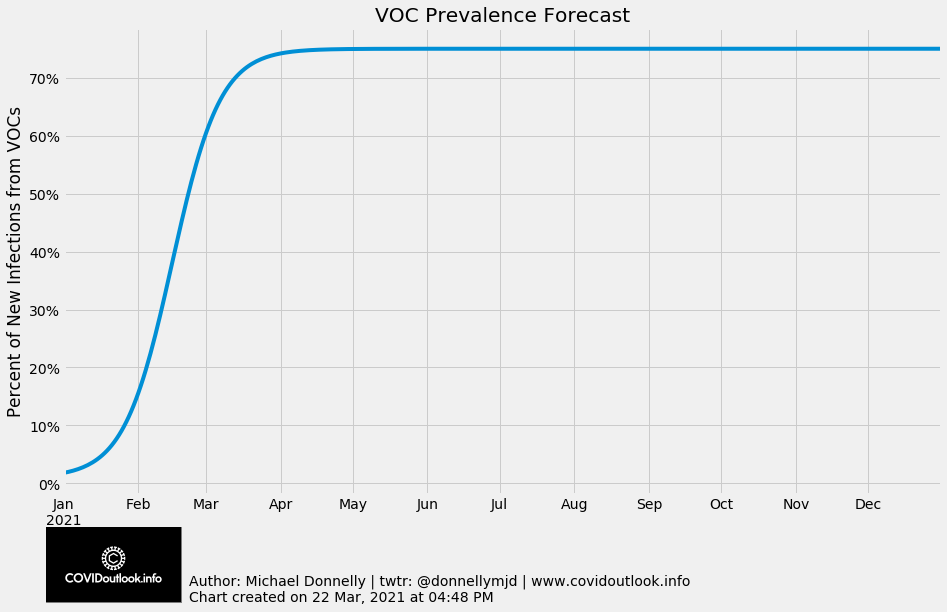

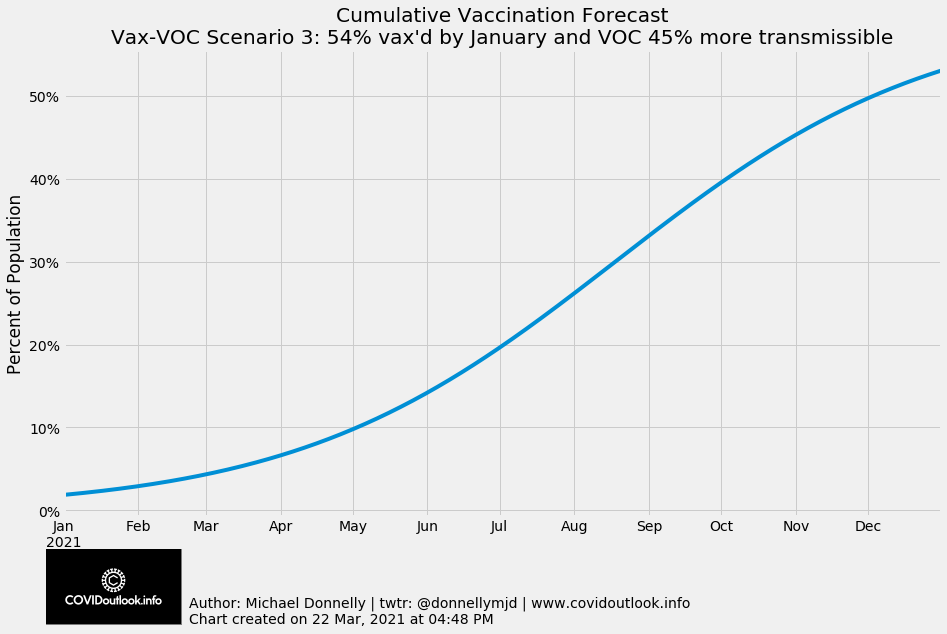

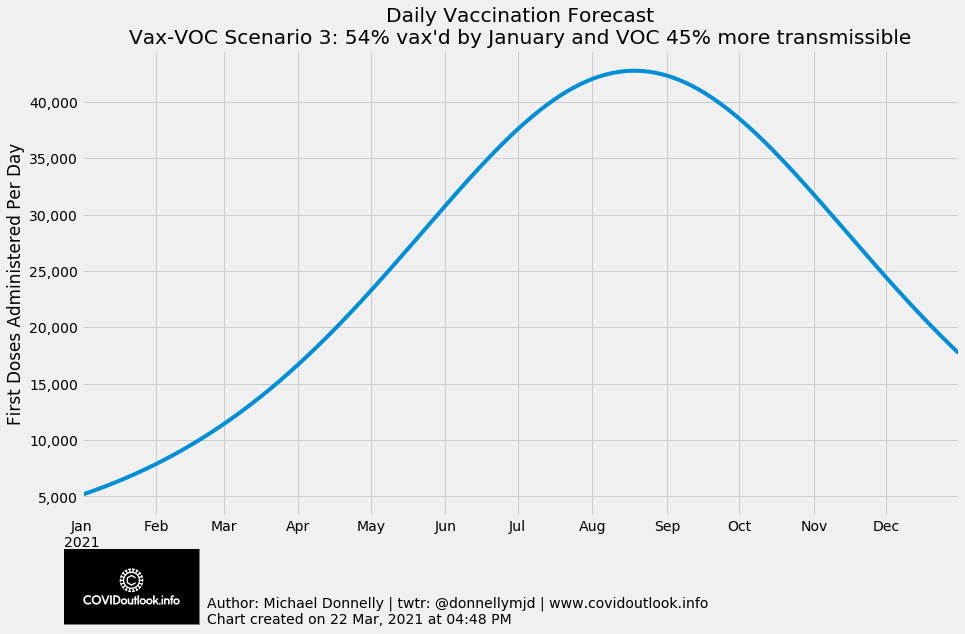

Capital Region
Central New York
Finger Lakes
Long Island
Mid-Hudson
Mohawk Valley
New York City
North Country
Southern Tier
Western New York


In [187]:
# # ########## Vax-VOC Scenario 3 ##########
# scenname = 'model_dict_scen_vaxvoc3'
# ht_variant_pct_more_transmissible = 0.45
# ht_variant_prev_curr = 1/100
# ht_variant_prev_3m = 0.75
# tspan = np.arange(0, 365, 1)

# # Calculate Prevalence forecast
# ht_variant_prev_t = ( (ht_variant_prev_curr - ht_variant_prev_3m)
#                     / (1 + np.exp(0.1 * (tspan - 45) ) )
#                     + ht_variant_prev_3m)
# ht_variant_prev_idx = pd.date_range(start = (pd.Timestamp('2021-01-01')), 
#                             periods = 365, 
#                             freq = '1D')
# ht_variant_prev_t = pd.Series(ht_variant_prev_t, index = ht_variant_prev_idx)
# ax = ht_variant_prev_t.plot(figsize=[14, 8], title = 'VOC Prevalence Forecast')
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# ax.set_xlabel('')
# ax.set_ylabel('Percent of New Infections from VOCs')
# ax = add_logo(ax)
# plt.annotate(footnote_str_maker(),
#              (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')
# plt.show()

# # https://covid19vaccine.health.ny.gov/covid-19-vaccine-tracker
# # https://covid.cdc.gov/covid-data-tracker/#vaccinations
# vaccine_effectiveness = 0.94
# vaccine_prop_max = 0.6
# speed_of_rollout = 0.015
# curr_vaxxed = 1.1e6
# totpop = 19e6

# vaccine_prop_curr = 0 
# tspan = np.arange(0, 365*3, 1)

# # Calculate Prevalence forecast

# vaccine_prop_t = ( (vaccine_prop_curr - (vaccine_prop_max) )
#                     / (1 + np.exp(speed_of_rollout * (tspan - 500) ) )
#                     + vaccine_prop_max)
# vaccine_prop_t = pd.Series(vaccine_prop_t)
# curr_vax_idx = vaccine_prop_t[vaccine_prop_t >= curr_vaxxed / totpop].first_valid_index()
# today_idx = (pd.Timestamp.today() - pd.Timestamp('2020-01-01')).days
# vaccine_prop_idx = pd.date_range(start = (pd.Timestamp('2020-01-01')), 
#                             periods = 365*3, 
#                             freq = '1D')
# vaccine_prop_t.index = vaccine_prop_idx
# vaccine_prop_t = vaccine_prop_t.shift(today_idx - curr_vax_idx).fillna(method='ffill').fillna(method='bfill')
# dt_vax_90p_done = vaccine_prop_t[vaccine_prop_t >= vaccine_prop_max * .9].first_valid_index()

# this_scenario_title = f'Vax-VOC Scenario 3: {vaccine_prop_max* .9:.0%} vax\'d by {dt_vax_90p_done.strftime("%B")} and VOC {ht_variant_pct_more_transmissible:.0%} more transmissible'

# ax = vaccine_prop_t.loc['2021-01-01':'2021-12-31'].plot(figsize=[14, 8], title = 'Cumulative Vaccination Forecast\n'+this_scenario_title)
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# ax.set_xlabel('')
# ax.set_ylabel('Percent of Population')
# ax = add_logo(ax)
# plt.annotate(footnote_str_maker(),
#              (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')

# plt.show()
# ax = vaccine_prop_t.mul(totpop).diff().loc['2021-01-01':'2021-12-31'].plot(figsize=[14, 8], title = 'Daily Vaccination Forecast\n'+this_scenario_title)
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax.set_xlabel('')
# ax.set_ylabel('First Doses Administered Per Day')
# ax = add_logo(ax)
# plt.annotate(footnote_str_maker(),
#              (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')
# plt.show()

# import copy

# df_scen_vaxvoc3_fore_allregions = pd.DataFrame()

# for region in sorted(df_ny_pop[this_region_type].unique()):
#     print(region)
#     model_dict = allregion_model_dicts[region]
#     if scenname in model_dict.keys():
#         del model_dict[scenname]
# #     model_dict[scenname] = copy.deepcopy(model_dict)
#     model_dict[scenname] = dict((k, model_dict[k]) for k in l_scen_md_copy if k in model_dict)
#     for key in l_scen_md_deepcopy:
#         model_dict[scenname][key] = copy.deepcopy(model_dict[key])
    
#     model_dict[scenname]['vaccine_prop_t'] = vaccine_prop_t * vaccine_effectiveness
    
#     r_t = model_dict['df_rts']['weighted_average'].copy()
#     local_r0_date = r_t.loc['2020-02-01':'2020-04-30'].idxmax()
#     voc_multiplier = ht_variant_prev_t.loc[r_t.last_valid_index():] * ht_variant_pct_more_transmissible + 1
#     r_t = r_t.loc[local_r0_date:].fillna(method='ffill').mul(voc_multiplier).fillna(r_t)
#     model_dict[scenname]['df_rts']['rt_scenario'] = r_t

#     start_date = model_dict['df_agg'].first_valid_index() - pd.Timedelta(days=1)
#     exposed_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)
#     infectious_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)

#     model_dict[scenname] = seir_model_cohort(start_date, model_dict[scenname], 
#                                                        exposed_0, infectious_0)
#     model_dict[scenname]['chart_title'] = this_scenario_title
#     allregion_model_dicts[region] = model_dict
#     df_scen_vaxvoc3_fore_allregions = pd.concat([df_scen_vaxvoc3_fore_allregions,
#                                           pd.DataFrame(
#                                               model_dict[scenname]['df_agg'].stack(), 
#                                               columns=[region])], 
#                                          axis=1)
    

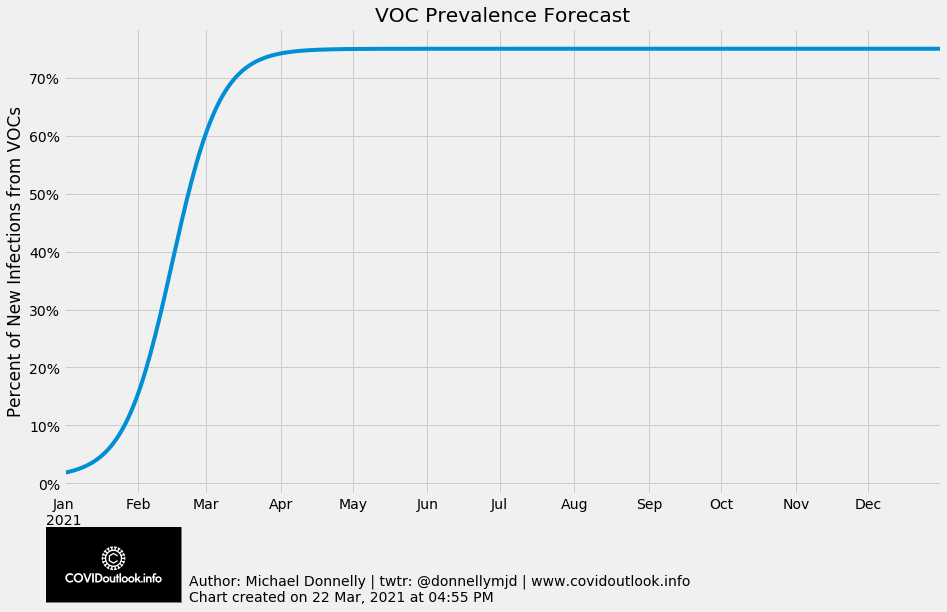

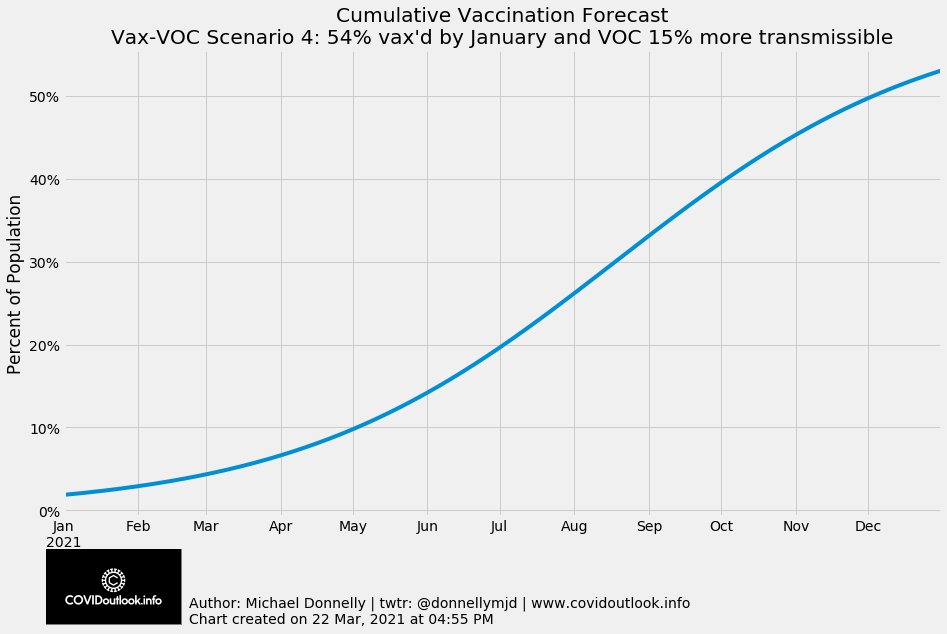

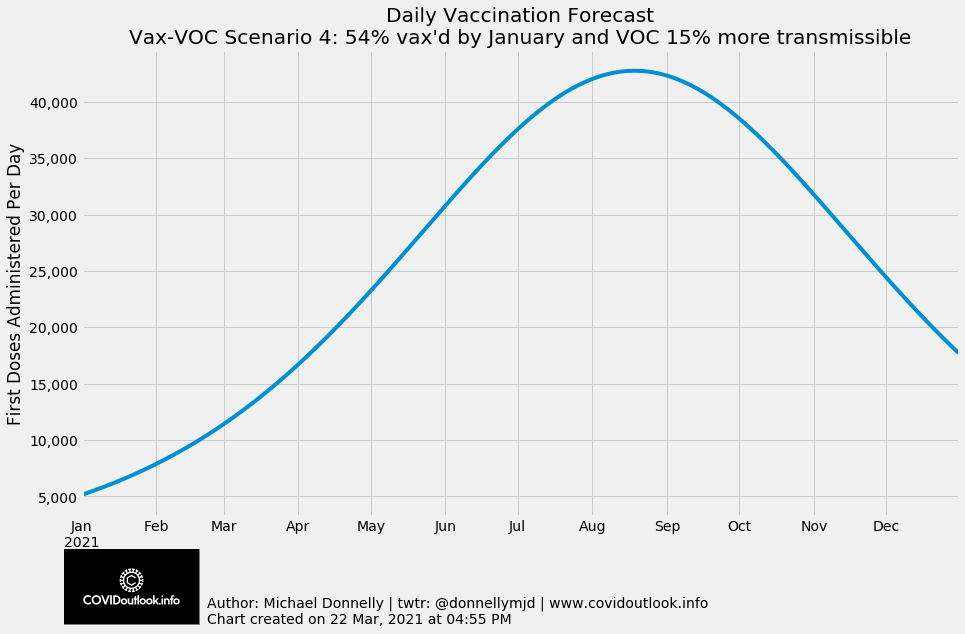

Capital Region
Central New York
Finger Lakes
Long Island
Mid-Hudson
Mohawk Valley
New York City
North Country
Southern Tier
Western New York


In [188]:
# # ########## Vax-VOC Scenario 4 ##########
# scenname = 'model_dict_scen_vaxvoc4'
# ht_variant_pct_more_transmissible = 0.15
# ht_variant_prev_curr = 1/100
# ht_variant_prev_3m = 0.75
# tspan = np.arange(0, 365, 1)

# # Calculate Prevalence forecast
# ht_variant_prev_t = ( (ht_variant_prev_curr - ht_variant_prev_3m)
#                     / (1 + np.exp(0.1 * (tspan - 45) ) )
#                     + ht_variant_prev_3m)
# ht_variant_prev_idx = pd.date_range(start = (pd.Timestamp('2021-01-01')), 
#                             periods = 365, 
#                             freq = '1D')
# ht_variant_prev_t = pd.Series(ht_variant_prev_t, index = ht_variant_prev_idx)
# ax = ht_variant_prev_t.plot(figsize=[14, 8], title = 'VOC Prevalence Forecast')
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# ax.set_xlabel('')
# ax.set_ylabel('Percent of New Infections from VOCs')
# ax = add_logo(ax)
# plt.annotate(footnote_str_maker(),
#              (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')
# plt.show()

# # https://covid19vaccine.health.ny.gov/covid-19-vaccine-tracker
# # https://covid.cdc.gov/covid-data-tracker/#vaccinations
# vaccine_effectiveness = 0.94
# vaccine_prop_max = 0.6
# speed_of_rollout = 0.015
# curr_vaxxed = 1.1e6
# totpop = 19e6

# vaccine_prop_curr = 0 
# tspan = np.arange(0, 365*3, 1)

# # Calculate Prevalence forecast

# vaccine_prop_t = ( (vaccine_prop_curr - (vaccine_prop_max) )
#                     / (1 + np.exp(speed_of_rollout * (tspan - 500) ) )
#                     + vaccine_prop_max)
# vaccine_prop_t = pd.Series(vaccine_prop_t)
# curr_vax_idx = vaccine_prop_t[vaccine_prop_t >= curr_vaxxed / totpop].first_valid_index()
# today_idx = (pd.Timestamp.today() - pd.Timestamp('2020-01-01')).days
# vaccine_prop_idx = pd.date_range(start = (pd.Timestamp('2020-01-01')), 
#                             periods = 365*3, 
#                             freq = '1D')
# vaccine_prop_t.index = vaccine_prop_idx
# vaccine_prop_t = vaccine_prop_t.shift(today_idx - curr_vax_idx).fillna(method='ffill').fillna(method='bfill')
# dt_vax_90p_done = vaccine_prop_t[vaccine_prop_t >= vaccine_prop_max * .9].first_valid_index()

# this_scenario_title = f'Vax-VOC Scenario 4: {vaccine_prop_max* .9:.0%} vax\'d by {dt_vax_90p_done.strftime("%B")} and VOC {ht_variant_pct_more_transmissible:.0%} more transmissible'

# ax = vaccine_prop_t.loc['2021-01-01':'2021-12-31'].plot(figsize=[14, 8], title = 'Cumulative Vaccination Forecast\n'+this_scenario_title)
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# ax.set_xlabel('')
# ax.set_ylabel('Percent of Population')
# ax = add_logo(ax)
# plt.annotate(footnote_str_maker(),
#              (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')

# plt.show()
# ax = vaccine_prop_t.mul(totpop).diff().loc['2021-01-01':'2021-12-31'].plot(figsize=[14, 8], title = 'Daily Vaccination Forecast\n'+this_scenario_title)
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax.set_xlabel('')
# ax.set_ylabel('First Doses Administered Per Day')
# ax = add_logo(ax)
# plt.annotate(footnote_str_maker(),
#              (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')
# plt.show()

# import copy

# df_scen_vaxvoc4_fore_allregions = pd.DataFrame()

# for region in sorted(df_ny_pop[this_region_type].unique()):
#     print(region)
#     model_dict = allregion_model_dicts[region]
#     if scenname in model_dict.keys():
#         del model_dict[scenname]
# #     model_dict[scenname] = copy.deepcopy(model_dict)
#     model_dict[scenname] = dict((k, model_dict[k]) for k in l_scen_md_copy if k in model_dict)
#     for key in l_scen_md_deepcopy:
#         model_dict[scenname][key] = copy.deepcopy(model_dict[key])
    
#     model_dict[scenname]['vaccine_prop_t'] = vaccine_prop_t * vaccine_effectiveness
    
#     r_t = model_dict['df_rts']['weighted_average'].copy()
#     local_r0_date = r_t.loc['2020-02-01':'2020-04-30'].idxmax()
#     voc_multiplier = ht_variant_prev_t.loc[r_t.last_valid_index():] * ht_variant_pct_more_transmissible + 1
#     r_t = r_t.loc[local_r0_date:].fillna(method='ffill').mul(voc_multiplier).fillna(r_t)
#     model_dict[scenname]['df_rts']['rt_scenario'] = r_t

#     start_date = model_dict['df_agg'].first_valid_index() - pd.Timedelta(days=1)
#     exposed_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)
#     infectious_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)

#     model_dict[scenname] = seir_model_cohort(start_date, model_dict[scenname], 
#                                                        exposed_0, infectious_0)
#     model_dict[scenname]['chart_title'] = this_scenario_title
#     allregion_model_dicts[region] = model_dict
#     df_scen_vaxvoc4_fore_allregions = pd.concat([df_scen_vaxvoc4_fore_allregions,
#                                           pd.DataFrame(
#                                               model_dict[scenname]['df_agg'].stack(), 
#                                               columns=[region])], 
#                                          axis=1)


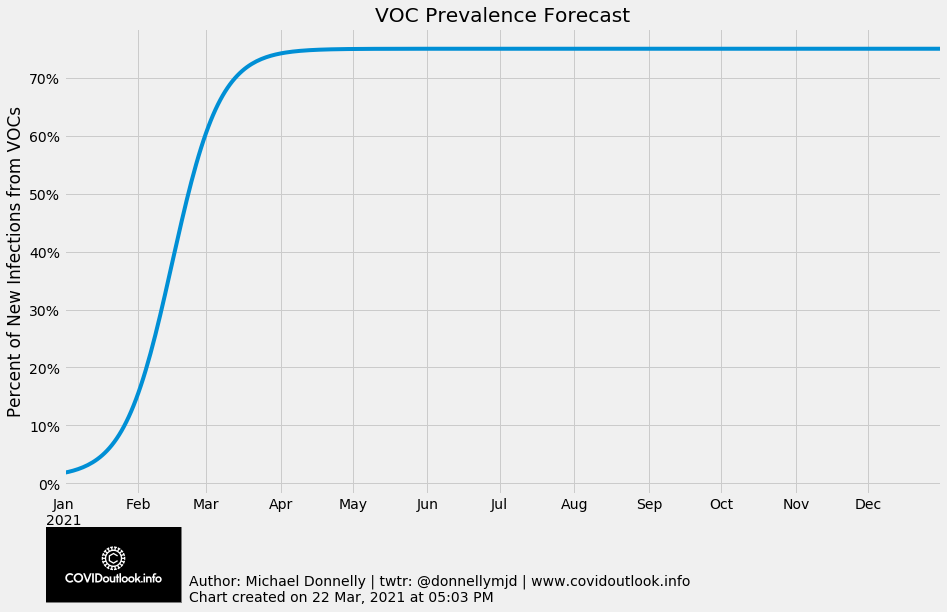

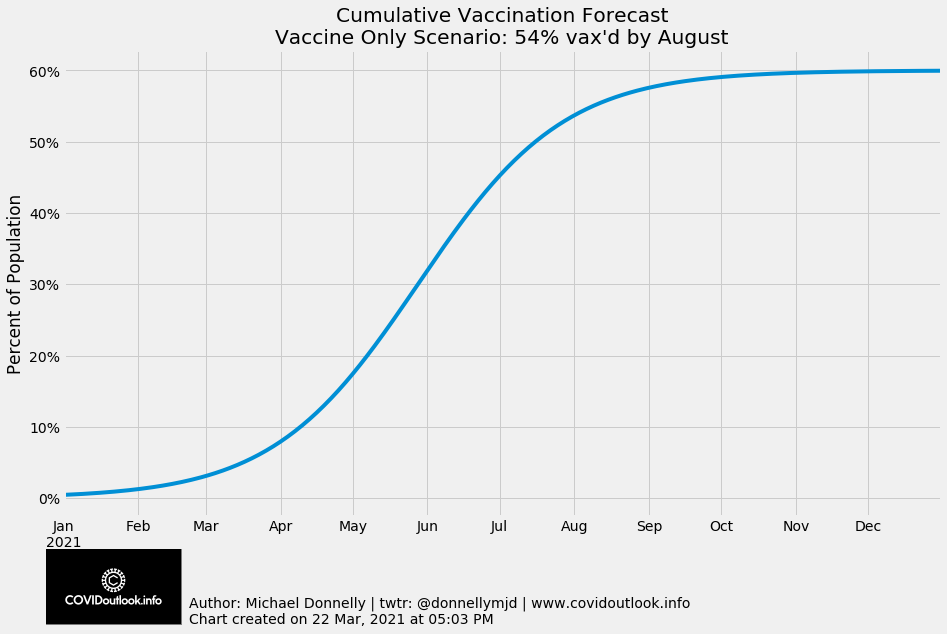

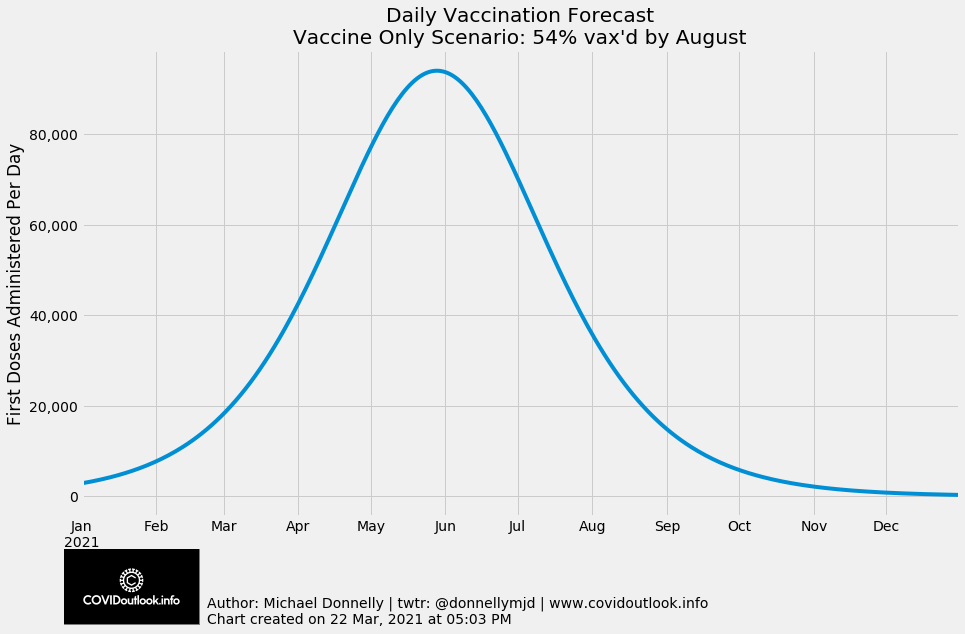

Capital Region
Central New York
Finger Lakes
Long Island
Mid-Hudson
Mohawk Valley
New York City
North Country
Southern Tier
Western New York


In [189]:
# # ########## Vax-Only Scenario ##########
# scenname = 'model_dict_scen_vax'
# ht_variant_pct_more_transmissible = 0.0
# ht_variant_prev_curr = 1/100
# ht_variant_prev_3m = 0.75
# tspan = np.arange(0, 365, 1)

# # Calculate Prevalence forecast
# ht_variant_prev_t = ( (ht_variant_prev_curr - ht_variant_prev_3m)
#                     / (1 + np.exp(0.1 * (tspan - 45) ) )
#                     + ht_variant_prev_3m)
# ht_variant_prev_idx = pd.date_range(start = (pd.Timestamp('2021-01-01')), 
#                             periods = 365, 
#                             freq = '1D')
# ht_variant_prev_t = pd.Series(ht_variant_prev_t, index = ht_variant_prev_idx)
# ax = ht_variant_prev_t.plot(figsize=[14, 8], title = 'VOC Prevalence Forecast')
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# ax.set_xlabel('')
# ax.set_ylabel('Percent of New Infections from VOCs')
# ax = add_logo(ax)
# plt.annotate(footnote_str_maker(),
#              (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')
# plt.show()

# # https://covid19vaccine.health.ny.gov/covid-19-vaccine-tracker
# # https://covid.cdc.gov/covid-data-tracker/#vaccinations
# vaccine_effectiveness = 0.94
# vaccine_prop_max = 0.6
# speed_of_rollout = 0.033
# curr_vaxxed = 1.1e6
# totpop = 19e6

# vaccine_prop_curr = 0 
# tspan = np.arange(0, 365*3, 1)

# # Calculate Prevalence forecast

# vaccine_prop_t = ( (vaccine_prop_curr - (vaccine_prop_max) )
#                     / (1 + np.exp(speed_of_rollout * (tspan - 500) ) )
#                     + vaccine_prop_max)
# vaccine_prop_t = pd.Series(vaccine_prop_t)
# curr_vax_idx = vaccine_prop_t[vaccine_prop_t >= curr_vaxxed / totpop].first_valid_index()
# today_idx = (pd.Timestamp.today() - pd.Timestamp('2020-01-01')).days
# vaccine_prop_idx = pd.date_range(start = (pd.Timestamp('2020-01-01')), 
#                             periods = 365*3, 
#                             freq = '1D')
# vaccine_prop_t.index = vaccine_prop_idx
# vaccine_prop_t = vaccine_prop_t.shift(today_idx - curr_vax_idx).fillna(method='ffill').fillna(method='bfill')
# dt_vax_90p_done = vaccine_prop_t[vaccine_prop_t >= vaccine_prop_max * .9].first_valid_index()

# this_scenario_title = f'Vaccine Only Scenario: {vaccine_prop_max* .9:.0%} vax\'d by {dt_vax_90p_done.strftime("%B")}'

# ax = vaccine_prop_t.loc['2021-01-01':'2021-12-31'].plot(figsize=[14, 8], title = 'Cumulative Vaccination Forecast\n'+this_scenario_title)
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# ax.set_xlabel('')
# ax.set_ylabel('Percent of Population')
# ax = add_logo(ax)
# plt.annotate(footnote_str_maker(),
#              (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')

# plt.show()
# ax = vaccine_prop_t.mul(totpop).diff().loc['2021-01-01':'2021-12-31'].plot(figsize=[14, 8], title = 'Daily Vaccination Forecast\n'+this_scenario_title)
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax.set_xlabel('')
# ax.set_ylabel('First Doses Administered Per Day')
# ax = add_logo(ax)
# plt.annotate(footnote_str_maker(),
#              (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')
# plt.show()

# import copy

# df_scen_vaxvoc2_fore_allregions = pd.DataFrame()

# for region in sorted(df_ny_pop[this_region_type].unique()):
#     print(region)
#     model_dict = allregion_model_dicts[region]
#     if scenname in model_dict.keys():
#         del model_dict[scenname]
# #     model_dict[scenname] = copy.deepcopy(model_dict)
#     model_dict[scenname] = dict((k, model_dict[k]) for k in l_scen_md_copy if k in model_dict)
#     for key in l_scen_md_deepcopy:
#         model_dict[scenname][key] = copy.deepcopy(model_dict[key])
    
#     model_dict[scenname]['vaccine_prop_t'] = vaccine_prop_t * vaccine_effectiveness
    
#     r_t = model_dict['df_rts']['weighted_average'].copy()
#     local_r0_date = r_t.loc['2020-02-01':'2020-04-30'].idxmax()
#     voc_multiplier = ht_variant_prev_t.loc[r_t.last_valid_index():] * ht_variant_pct_more_transmissible + 1
#     r_t = r_t.loc[local_r0_date:].fillna(method='ffill').mul(voc_multiplier).fillna(r_t)
#     model_dict[scenname]['df_rts']['rt_scenario'] = r_t

#     start_date = model_dict['df_agg'].first_valid_index() - pd.Timedelta(days=1)
#     exposed_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)
#     infectious_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)

#     model_dict[scenname] = seir_model_cohort(start_date, model_dict[scenname], 
#                                                        exposed_0, infectious_0)
#     model_dict[scenname]['chart_title'] = this_scenario_title
#     allregion_model_dicts[region] = model_dict
#     df_scen_vaxvoc2_fore_allregions = pd.concat([df_scen_vaxvoc2_fore_allregions,
#                                           pd.DataFrame(
#                                               model_dict[scenname]['df_agg'].stack(), 
#                                               columns=[region])], 
#                                          axis=1)


In [190]:
# # IDEA HERE IS TO SEE THE EFFECT OF GRADUALLY REMOVING NPIs. TO DO THIS, WE'LL NEED TO ADD IT INTO THE MODEL CODE.
# # WE WANT TO SEE WHAT THE EFFECT OF THE PRE-IMMUNE EFFECT RT GOING UP TO THE R0.
# test = allregion_model_dicts['Long Island']['df_rts']['weighted_average'].copy()
# test.loc['2021-07-01'] = test.max()
# test = test.interpolate()
# test.plot()


In [191]:
# # ########## Vax-VOC Scenario 5 ##########
# scenname = 'model_dict_scen_vaxvoc5'
# ht_variant_pct_more_transmissible = 0.7
# ht_variant_prev_curr = 1/100
# ht_variant_prev_3m = 0.75
# tspan = np.arange(0, 365, 1)

# # Calculate Prevalence forecast
# ht_variant_prev_t = ( (ht_variant_prev_curr - ht_variant_prev_3m)
#                     / (1 + np.exp(0.1 * (tspan - 45) ) )
#                     + ht_variant_prev_3m)
# ht_variant_prev_idx = pd.date_range(start = (pd.Timestamp('2021-01-01')), 
#                             periods = 365, 
#                             freq = '1D')
# ht_variant_prev_t = pd.Series(ht_variant_prev_t, index = ht_variant_prev_idx)

# # https://covid19vaccine.health.ny.gov/covid-19-vaccine-tracker
# # https://covid.cdc.gov/covid-data-tracker/#vaccinations
# vaccine_effectiveness = 0.94
# vaccine_prop_max = 0.6
# speed_of_rollout = 0.015
# curr_vaxxed = 1.1e6
# totpop = 19e6

# vaccine_prop_curr = 0 
# tspan = np.arange(0, 365*3, 1)

# # Calculate Prevalence forecast

# vaccine_prop_t = ( (vaccine_prop_curr - (vaccine_prop_max) )
#                     / (1 + np.exp(speed_of_rollout * (tspan - 500) ) )
#                     + vaccine_prop_max)
# vaccine_prop_t = pd.Series(vaccine_prop_t)
# curr_vax_idx = vaccine_prop_t[vaccine_prop_t >= curr_vaxxed / totpop].first_valid_index()
# today_idx = (pd.Timestamp.today() - pd.Timestamp('2020-01-01')).days
# vaccine_prop_idx = pd.date_range(start = (pd.Timestamp('2020-01-01')), 
#                             periods = 365*3, 
#                             freq = '1D')
# vaccine_prop_t.index = vaccine_prop_idx
# vaccine_prop_t = vaccine_prop_t.shift(today_idx - curr_vax_idx).fillna(method='ffill').fillna(method='bfill')
# dt_vax_90p_done = vaccine_prop_t[vaccine_prop_t >= vaccine_prop_max * .9].first_valid_index()

# this_scenario_title = f'Vax-VOC Scenario 5: {vaccine_prop_max* .9:.0%} vax\'d by {dt_vax_90p_done.strftime("%B")} and VOC {ht_variant_pct_more_transmissible:.0%} more transmissible'

# ax = vaccine_prop_t.loc['2021-01-01':'2021-12-31'].plot(figsize=[14, 8], title = 'Cumulative Vaccination Forecast\n'+this_scenario_title)
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# ax.set_xlabel('')
# ax.set_ylabel('Percent of Population')
# ax = add_logo(ax)
# plt.annotate(model_dict['footnote_str'],
#              (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')

# plt.show()
# ax = vaccine_prop_t.mul(totpop).diff().loc['2021-01-01':'2021-12-31'].plot(figsize=[14, 8], title = 'Daily Vaccination Forecast\n'+this_scenario_title)
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax.set_xlabel('')
# ax.set_ylabel('First Doses Administered Per Day')
# ax = add_logo(ax)
# plt.annotate(model_dict['footnote_str'],
#              (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')
# plt.show()

# import copy

# df_scen_vaxvoc3_fore_allregions = pd.DataFrame()

# for region in sorted(df_ny_pop[this_region_type].unique()):
#     print(region)
#     model_dict = allregion_model_dicts[region]
#     if scenname in model_dict.keys():
#         del model_dict[scenname]
# #     model_dict[scenname] = copy.deepcopy(model_dict)
#     model_dict[scenname] = dict((k, model_dict[k]) for k in l_scen_md_copy if k in model_dict)
#     for key in l_scen_md_deepcopy:
#         model_dict[scenname][key] = copy.deepcopy(model_dict[key])
    
#     model_dict[scenname]['vaccine_prop_t'] = vaccine_prop_t * vaccine_effectiveness
    
#     r_t = model_dict['df_rts']['weighted_average'].copy()
#     local_r0_date = r_t.loc['2020-02-01':'2020-04-30'].idxmax()
#     voc_multiplier = ht_variant_prev_t.loc[r_t.last_valid_index():] * ht_variant_pct_more_transmissible + 1
#     r_t = r_t.loc[local_r0_date:].fillna(method='ffill').mul(voc_multiplier).fillna(r_t)
#     model_dict[scenname]['df_rts']['rt_scenario'] = r_t

#     start_date = model_dict['df_agg'].first_valid_index() - pd.Timedelta(days=1)
#     exposed_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)
#     infectious_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)

#     model_dict[scenname] = seir_model_cohort(start_date, model_dict[scenname], 
#                                                        exposed_0, infectious_0)
#     model_dict[scenname]['chart_title'] = this_scenario_title
#     allregion_model_dicts[region] = model_dict
#     df_scen_vaxvoc3_fore_allregions = pd.concat([df_scen_vaxvoc3_fore_allregions,
#                                           pd.DataFrame(
#                                               model_dict[scenname]['df_agg'].stack(), 
#                                               columns=[region])], 
#                                          axis=1)
    

In [192]:
# ########## HOLIDAY SPIKE SCENARIO 1 ##########
# import copy

# df_scen1_fore_allregions = pd.DataFrame()

# for region in sorted(df_ny_pop[this_region_type].unique()):
#     print(region)
#     model_dict = allregion_model_dicts[region]
#     if 'model_dict_scen1' in model_dict.keys():
#         del model_dict['model_dict_scen1']
#     model_dict['model_dict_scen1'] = copy.deepcopy(model_dict)
    
#     if model_dict['df_rts']['weighted_average'].last_valid_index() < pd.Timestamp('2020-11-24'):
#         model_dict['model_dict_scen1']['df_rts'].loc['2020-11-24':'2020-11-30','rt_scenario'] = \
#             model_dict['model_dict_scen1']['df_rts'].loc['2020-11-24':'2020-11-30','rt_scenario']\
#             .mul(1.2).clip(upper=2.3)
    
#     if model_dict['df_rts']['weighted_average'].last_valid_index() < pd.Timestamp('2020-12-24'):
#         model_dict['model_dict_scen1']['df_rts'].loc['2020-12-24':'2021-01-01','rt_scenario'] = \
#             model_dict['model_dict_scen1']['df_rts'].loc['2020-12-24':'2021-01-01','rt_scenario']\
#             .mul(1.2).clip(upper=2.3)

#     start_date = model_dict['df_agg'].first_valid_index() - pd.Timedelta(days=1)
#     exposed_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)
#     infectious_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)

#     model_dict['model_dict_scen1'] = seir_model_cohort(start_date, model_dict['model_dict_scen1'], 
#                                                        exposed_0, infectious_0)
#     model_dict['model_dict_scen1']['chart_title'] = \
#         r'20% increase in $R_{t}$ Over T\'giving, Xmas, New Year, Reaching Hospital Capacity Triggers Lockdown'
#     allregion_model_dicts[region] = model_dict
#     df_scen1_fore_allregions = pd.concat([df_scen1_fore_allregions,
#                                           pd.DataFrame(
#                                               model_dict['model_dict_scen1']['df_agg'].stack(), 
#                                               columns=[region])], 
#                                          axis=1)


In [193]:
# ########## HOLIDAY SPIKE SCENARIO 2 ##########
# import copy

# df_scen2_fore_allregions = pd.DataFrame()

# for region in sorted(df_ny_pop[this_region_type].unique()):
#     print(region)
#     model_dict = allregion_model_dicts[region]
#     if 'model_dict_scen2' in model_dict.keys():
#         del model_dict['model_dict_scen2']
#     model_dict['model_dict_scen2'] = copy.deepcopy(model_dict)
    
#     last_obs_dt_rt = model_dict['df_rts']['weighted_average'].last_valid_index()
    
#     if last_obs_dt_rt < pd.Timestamp('2020-11-24'):
#         model_dict['model_dict_scen2']['df_rts'].loc['2020-11-24':'2020-11-30','rt_scenario'] = \
#             model_dict['model_dict_scen2']['df_rts'].loc['2020-11-24':'2020-11-30','rt_scenario']\
#             .mul(1.2).clip(upper=2.3)
    
#     if last_obs_dt_rt < pd.Timestamp('2020-12-24'):
#         pre_tgiving_median = model_dict['df_rts']['weighted_average'].loc['2020-11-01':'2020-11-24'].quantile(.5)
        
#         model_dict['model_dict_scen2']['df_rts'].loc[max(last_obs_dt_rt,pd.Timestamp('2020-12-01')):,'rt_scenario'] = \
#             min(pre_tgiving_median, model_dict['df_rts']['weighted_average'].loc[last_obs_dt_rt])

#         model_dict['model_dict_scen2']['df_rts'].loc['2020-12-24':'2021-01-01','rt_scenario'] = \
#             model_dict['model_dict_scen2']['df_rts'].loc['2020-12-24':'2021-01-01','rt_scenario']\
#             .mul(1.2).clip(upper=2.3)

#     start_date = model_dict['df_agg'].first_valid_index() - pd.Timedelta(days=1)
#     exposed_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)
#     infectious_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)

#     model_dict['model_dict_scen2'] = seir_model_cohort(start_date, model_dict['model_dict_scen2'], 
#                                                        exposed_0, infectious_0)
#     model_dict['model_dict_scen2']['chart_title'] = \
#         r'Post-Tgiving decline in $R_{t}$ until 20% spike over Xmas, Reaching Hospital Capacity Triggers Lockdown'
#     allregion_model_dicts[region] = model_dict
#     df_scen2_fore_allregions = pd.concat([df_scen2_fore_allregions,
#                                           pd.DataFrame(
#                                               model_dict['model_dict_scen2']['df_agg'].stack(), 
#                                               columns=[region])], 
#                                          axis=1)


In [33]:
# ########## NEW VAX SCEN ##########
scenname = 'model_dict_scen_vaccine1'

from my_can_apikey import can_apikey
df_can_raw = pd.read_csv(f'https://api.covidactnow.org/v2/states.timeseries.csv?apiKey={can_apikey}')
df_can = df_can_raw.copy()

df_can['dt'] = pd.to_datetime(df_can['date'])
df_can = df_can.set_index(['state','dt'])


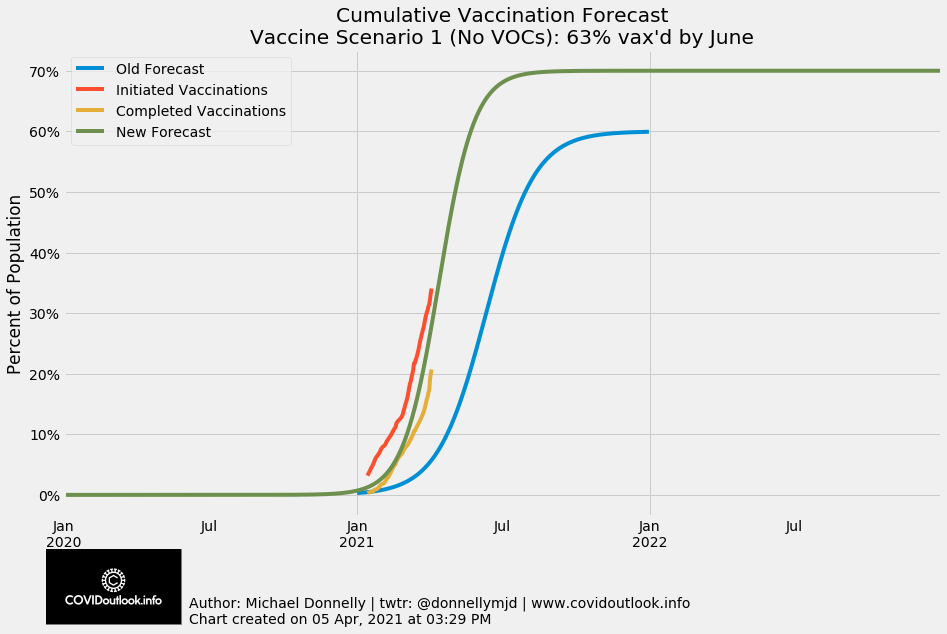

In [56]:
# ########## Vaccine SCENARIO 1 ##########
scenname = 'model_dict_scen_vaccine1'
# https://covid19vaccine.health.ny.gov/covid-19-vaccine-tracker
# https://covid.cdc.gov/covid-data-tracker/#vaccinations
vaccine_effectiveness = 0.94
vaccine_prop_max = 0.6
speed_of_rollout = 0.033
curr_vaxxed = 1.1e6
totpop = 19e6

vaccine_prop_curr = 0 
tspan = np.arange(0, 365*3, 1)

# Calculate Vax forecast
vaccine_prop_t = ( (vaccine_prop_curr - (vaccine_prop_max) )
                    / (1 + np.exp(speed_of_rollout * (tspan - 500) ) )
                    + vaccine_prop_max)
vaccine_prop_t = pd.Series(vaccine_prop_t)
curr_vax_idx = vaccine_prop_t[vaccine_prop_t >= curr_vaxxed / totpop].first_valid_index()
today_idx = (pd.Timestamp.today() - pd.Timestamp('2020-01-01')).days
vaccine_prop_idx = pd.date_range(start = (pd.Timestamp('2020-01-01')), 
                            periods = 365*3, 
                            freq = '1D')
vaccine_prop_t.index = vaccine_prop_idx
vaccine_prop_t = vaccine_prop_t.shift(today_idx - curr_vax_idx).fillna(method='ffill').fillna(method='bfill')
dt_vax_90p_done = vaccine_prop_t[vaccine_prop_t >= vaccine_prop_max * .9].first_valid_index()

# Calc New Vax Forecast
vaccine_effectiveness = 0.9
vaccine_prop_max = 0.7
speed_of_rollout = 0.045
curr_vaxxed = ( df_can.loc['NY','actuals.vaccinationsInitiated'].dropna().iloc[-1]
               + df_can.loc['NY','actuals.vaccinationsCompleted'].dropna().iloc[-1]) / 2
totpop = 19e6

vaccine_prop_curr = 0 
tspan = np.arange(0, 365*3, 1)

# Calculate Vax forecast
vaccine_prop_t_new = ( (vaccine_prop_curr - (vaccine_prop_max) )
                    / (1 + np.exp(speed_of_rollout * (tspan - 400) ) )
                    + vaccine_prop_max)
vaccine_prop_t_new = pd.Series(vaccine_prop_t_new)
curr_vax_idx = vaccine_prop_t_new[vaccine_prop_t_new >= curr_vaxxed / totpop].first_valid_index()
today_idx = (pd.Timestamp.today() - pd.Timestamp('2020-01-01')).days
vaccine_prop_t_new.index = pd.date_range(start = (pd.Timestamp('2020-01-01')), 
                            periods = 365*3, 
                            freq = '1D')
vaccine_prop_t_new = vaccine_prop_t_new.shift(today_idx - curr_vax_idx).fillna(method='ffill').fillna(method='bfill')
dt_vax_90p_done = vaccine_prop_t_new[vaccine_prop_t_new >= vaccine_prop_max * .9].first_valid_index()

this_scenario_title = f'Vaccine Scenario 1 (No VOCs): {vaccine_prop_max * .9:.0%} vax\'d by {dt_vax_90p_done.strftime("%B")}'

ax = vaccine_prop_t.loc['2021-01-01':'2021-12-31'].plot(
    figsize=[14, 8], label='Old Forecast', legend=True,
    title = 'Cumulative Vaccination Forecast\n'+this_scenario_title)
df_can.loc['NY','metrics.vaccinationsInitiatedRatio'].dropna().plot(
    ax=ax, legend=True, label='Initiated Vaccinations')
df_can.loc['NY','metrics.vaccinationsCompletedRatio'].dropna().plot(
    ax=ax, legend=True, label='Completed Vaccinations')
vaccine_prop_t_new.plot(ax=ax, legend=True, label='New Forecast')

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
ax.set_xlabel('')
ax.set_ylabel('Percent of Population')
ax = add_logo(ax)
plt.annotate(model_dict['footnote_str'],
             (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')

plt.show()


In [57]:
import copy

df_scen_vaccine1_fore_allregions = pd.DataFrame()
vaccine_prop_t = vaccine_prop_t_new

for region in sorted(df_ny_pop[this_region_type].unique()):
    print(region)
    model_dict = allregion_model_dicts[region]
    if scenname in model_dict.keys():
        del model_dict[scenname]
#     model_dict[scenname] = copy.deepcopy(model_dict)
    model_dict[scenname] = dict((k, model_dict[k]) for k in l_scen_md_copy if k in model_dict)
    for key in l_scen_md_deepcopy:
        model_dict[scenname][key] = copy.deepcopy(model_dict[key])
    
    model_dict[scenname]['vaccine_prop_t'] = vaccine_prop_t * vaccine_effectiveness

    start_date = model_dict['df_agg'].first_valid_index() - pd.Timedelta(days=1)
    exposed_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)
    infectious_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)

    model_dict[scenname] = seir_model_cohort(start_date, model_dict[scenname], 
                                                       exposed_0, infectious_0)
    model_dict[scenname]['chart_title'] = this_scenario_title
    allregion_model_dicts[region] = model_dict
    df_scen_vaccine1_fore_allregions = pd.concat([df_scen_vaccine1_fore_allregions,
                                          pd.DataFrame(
                                              model_dict[scenname]['df_agg'].stack(), 
                                              columns=[region])], 
                                         axis=1)

Capital Region
Central New York
Finger Lakes
Long Island
Mid-Hudson
Mohawk Valley
New York City
North Country
Southern Tier
Western New York


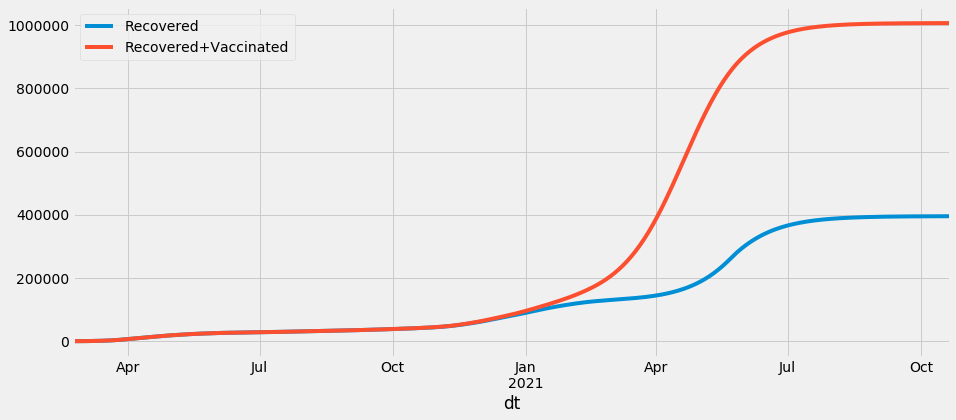

In [80]:
ax=model_dict['df_agg']['recovered'].plot(label='Recovered', legend=True, figsize=[14,6])
model_dict['model_dict_scen_vaccine1']['df_agg']['recovered'].plot(ax=ax, label='Recovered+Vaccinated',
                                                                   legend=True, figsize=[14,6])

In [74]:
model_dict

{'region_code': 'Western New York',
 'region_name': 'Western New York',
 'tot_pop': 1377094,
 'df_hist':             deaths_tot  deaths_daily  hosp_concur  hosp_admits  cases_tot  \
 dt                                                                          
 2020-03-03         0.0           NaN          0.0          0.0        0.0   
 2020-03-04         0.0           0.0          0.0          0.0        0.0   
 2020-03-05         0.0           0.0          0.0          0.0        0.0   
 2020-03-06         0.0           0.0          0.0          0.0        0.0   
 2020-03-07         0.0           0.0          0.0          0.0        0.0   
 ...                ...           ...          ...          ...        ...   
 2021-03-31      1393.0           1.0        220.0         27.0   106953.0   
 2021-04-01      1397.0           4.0        220.0         37.0   107495.0   
 2021-04-02      1401.0           4.0        230.0         47.0   108109.0   
 2021-04-03      1404.0           3.0 

In [1]:
ax= model_dict['df_rts']['rt_scenario'].plot(label='Effective Rt', legend=True, figsize=[14,6])
pre_immune_rt = model_dict['df_rts']['rt_scenario'].div(
    1-(model_dict['df_agg']['recovered'] / model_dict['tot_pop']))
pre_immune_rt.plot(ax=ax, label='Pre-Immunity/Behavioral Rt', legend=True)
r0 = pre_immune_rt.loc['2020-01-01':'2020-05-01'].max()



NameError: name 'model_dict' is not defined

/Users/mdonnelly/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


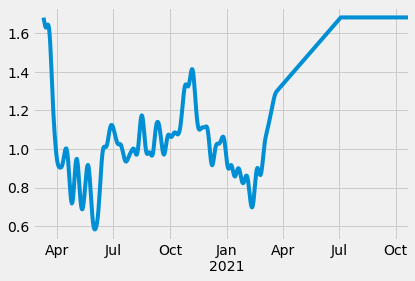

In [86]:
rt_partysummer = model_dict['df_rts']['weighted_average']
rt_partysummer.loc['2021-07-04'] = r0
rt_partysummer = rt_partysummer.interpolate()
rt_partysummer.plot()

In [ ]:
# ########## Vax-VOC Scenario 5 ##########
scenname = 'model_dict_scen_vaxvoc5'
ht_variant_pct_more_transmissible = 0.7
ht_variant_prev_curr = 1/100
ht_variant_prev_3m = 0.75
tspan = np.arange(0, 365, 1)

# Calculate Prevalence forecast
ht_variant_prev_t = ( (ht_variant_prev_curr - ht_variant_prev_3m)
                    / (1 + np.exp(0.1 * (tspan - 45) ) )
                    + ht_variant_prev_3m)
ht_variant_prev_idx = pd.date_range(start = (pd.Timestamp('2021-01-01')), 
                            periods = 365, 
                            freq = '1D')
ht_variant_prev_t = pd.Series(ht_variant_prev_t, index = ht_variant_prev_idx)

# https://covid19vaccine.health.ny.gov/covid-19-vaccine-tracker
# https://covid.cdc.gov/covid-data-tracker/#vaccinations
vaccine_effectiveness = 0.94
vaccine_prop_max = 0.6
speed_of_rollout = 0.015
curr_vaxxed = 1.1e6
totpop = 19e6

vaccine_prop_curr = 0 
tspan = np.arange(0, 365*3, 1)

# Calculate Prevalence forecast

vaccine_prop_t = ( (vaccine_prop_curr - (vaccine_prop_max) )
                    / (1 + np.exp(speed_of_rollout * (tspan - 500) ) )
                    + vaccine_prop_max)
vaccine_prop_t = pd.Series(vaccine_prop_t)
curr_vax_idx = vaccine_prop_t[vaccine_prop_t >= curr_vaxxed / totpop].first_valid_index()
today_idx = (pd.Timestamp.today() - pd.Timestamp('2020-01-01')).days
vaccine_prop_idx = pd.date_range(start = (pd.Timestamp('2020-01-01')), 
                            periods = 365*3, 
                            freq = '1D')
vaccine_prop_t.index = vaccine_prop_idx
vaccine_prop_t = vaccine_prop_t.shift(today_idx - curr_vax_idx).fillna(method='ffill').fillna(method='bfill')
dt_vax_90p_done = vaccine_prop_t[vaccine_prop_t >= vaccine_prop_max * .9].first_valid_index()

this_scenario_title = f'Vax-VOC Scenario 5: {vaccine_prop_max* .9:.0%} vax\'d by {dt_vax_90p_done.strftime("%B")} and VOC {ht_variant_pct_more_transmissible:.0%} more transmissible'

ax = vaccine_prop_t.loc['2021-01-01':'2021-12-31'].plot(figsize=[14, 8], title = 'Cumulative Vaccination Forecast\n'+this_scenario_title)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
ax.set_xlabel('')
ax.set_ylabel('Percent of Population')
ax = add_logo(ax)
plt.annotate(model_dict['footnote_str'],
             (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')

plt.show()
ax = vaccine_prop_t.mul(totpop).diff().loc['2021-01-01':'2021-12-31'].plot(figsize=[14, 8], title = 'Daily Vaccination Forecast\n'+this_scenario_title)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('')
ax.set_ylabel('First Doses Administered Per Day')
ax = add_logo(ax)
plt.annotate(model_dict['footnote_str'],
             (0, 0), (125, -80), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

import copy

df_scen_vaxvoc3_fore_allregions = pd.DataFrame()

for region in sorted(df_ny_pop[this_region_type].unique()):
    print(region)
    model_dict = allregion_model_dicts[region]
    if scenname in model_dict.keys():
        del model_dict[scenname]
#     model_dict[scenname] = copy.deepcopy(model_dict)
    model_dict[scenname] = dict((k, model_dict[k]) for k in l_scen_md_copy if k in model_dict)
    for key in l_scen_md_deepcopy:
        model_dict[scenname][key] = copy.deepcopy(model_dict[key])
    
    model_dict[scenname]['vaccine_prop_t'] = vaccine_prop_t * vaccine_effectiveness
    
    r_t = model_dict['df_rts']['weighted_average'].copy()
    local_r0_date = r_t.loc['2020-02-01':'2020-04-30'].idxmax()
    voc_multiplier = ht_variant_prev_t.loc[r_t.last_valid_index():] * ht_variant_pct_more_transmissible + 1
    r_t = r_t.loc[local_r0_date:].fillna(method='ffill').mul(voc_multiplier).fillna(r_t)
    model_dict[scenname]['df_rts']['rt_scenario'] = r_t

    start_date = model_dict['df_agg'].first_valid_index() - pd.Timedelta(days=1)
    exposed_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)
    infectious_0 = max(min(model_dict['df_hist']['cases_tot'].max() / 100, 100), 10)

    model_dict[scenname] = seir_model_cohort(start_date, model_dict[scenname], 
                                                       exposed_0, infectious_0)
    model_dict[scenname]['chart_title'] = this_scenario_title
    allregion_model_dicts[region] = model_dict
    df_scen_vaxvoc3_fore_allregions = pd.concat([df_scen_vaxvoc3_fore_allregions,
                                          pd.DataFrame(
                                              model_dict[scenname]['df_agg'].stack(), 
                                              columns=[region])], 
                                         axis=1)
    

In [87]:
for region in allregion_model_dicts.keys():
    allregion_model_dicts[region]['model_dict_scen_standard'] = allregion_model_dicts[region]

l_scenarios = [key for key in allregion_model_dicts[region].keys() if key[:11] == 'model_dict_']

d_scenarios = {}

for scenname in l_scenarios:
    d_scenarios[scenname[11:]] = pd.DataFrame()
    for region in allregion_model_dicts.keys():
        this_region_scen = pd.DataFrame(
            allregion_model_dicts[region][scenname]['df_agg'].stack(), columns=[region])
        d_scenarios[scenname[11:]] = pd.concat([d_scenarios[scenname[11:]], this_region_scen], axis=1)
        
    d_scenarios[scenname[11:]]['--NYS Total--'] = d_scenarios[scenname[11:]].sum(axis=1)
    d_scenarios[scenname[11:]] = d_scenarios[scenname[11:]].unstack('metric').swaplevel(axis=1).sort_index(axis=1)
    d_scenarios[scenname[11:]].to_csv('./output/nys_fore/nys_{}_{}.csv'.format(
        scenname[11:], pd.Timestamp.today().strftime("%Y%m%d")))


In [88]:
df_tab = df_ny_pop.groupby(this_region_type).sum()[['pop2019']].copy()
# df_tab = df_tab.set_index('state')
df_ger = df_nys.groupby(level=[this_region_type,'dt']).sum().unstack(0)

# Days to Hosp Capacity
# df_tab['hosp_cap'] = df_tab['pop2019'] / 1000 * 2.7 * 0.2
df_tab['hosp_cap'] = df_ger['hosp_beds_avail'].fillna(method='ffill').add(
    df_ger['Total hospitalizations_county'].fillna(method='ffill')).iloc[-1]
df_hosp_conur = df_fore_allregions[[col for col in df_fore_allregions.columns if col != 'US']] \
                    .unstack('dt').loc['hospitalized'].T.unstack(0).loc[
                pd.Timestamp.today() - pd.Timedelta(days=30):]
df_hosp_cap_rat = df_hosp_conur.div(df_tab['hosp_cap'])
df_tab['Forecasted Hospital Capacity Date'] = pd.to_datetime(
    df_hosp_cap_rat.mask(df_hosp_cap_rat < 1).apply(lambda x: x.first_valid_index()) )
df_tab['Days to Hospital Capacity'] = (df_tab['Forecasted Hospital Capacity Date']-pd.Timestamp.today()).dt.days
df_tab['Forecasted Hospital Capacity Date'] = df_tab['Forecasted Hospital Capacity Date'].dt.strftime("%m/%d/%y")
df_tab['Forecasted Hospital Capacity Date'] = df_tab['Forecasted Hospital Capacity Date'].fillna(
    'Beds Available Through Forecast')
    
# Deaths
df_tab['Total Deaths per 100k'] = df_ger['Cumulative hosp deaths_county'].fillna(method='ffill').iloc[-1] \
    .div(df_tab.pop2019).mul(1e5)
df_tab['14-Day Avg Daily Deaths per 100k'] = df_ger['Cumulative hosp deaths_county'].fillna(method='ffill') \
    .diff().rolling(14).mean().iloc[-1].div(df_tab.pop2019).mul(1e5)
df_tab['deaths_trend'] = calc_trend(
    df_ger['Cumulative hosp deaths_county'].fillna(method='ffill').div(df_tab.pop2019).mul(1e5).diff(),
    0.02)
# Cases
df_tab['Total Cases per 100k'] = df_ger['Positive tests_county'].cumsum().fillna(method='ffill').iloc[-1] \
    .div(df_tab.pop2019).mul(1e5)
df_tab['14-Day Avg Daily Cases per 100k'] = df_ger['Positive tests_county'].cumsum().fillna(method='ffill') \
    .diff().rolling(14).mean().iloc[-1].div(df_tab.pop2019).mul(1e5)
df_tab['cases_trend'] = calc_trend(
    df_ger['Positive tests_county'].cumsum().fillna(method='ffill').div(df_tab.pop2019).mul(1e5).diff(),
    0.5)
# Positivity Rate
df_tab['Positivity Rate'] = df_ger['Positive tests_county'].rolling(14).sum().iloc[-1].div(
    df_ger['Daily tests_county'].rolling(14).sum().iloc[-1])
df_tab['positivity_trend'] = calc_trend(
    df_ger['Positive tests_county'].rolling(14).sum().div(
        df_ger['Daily tests_county'].rolling(14).sum()),
    0.0005)
# Hospitalizations
df_tab['Hospitalized per 100k'] = df_ger['Total hospitalizations_county'].fillna(method='ffill').iloc[-1] \
    .div(df_tab.pop2019).mul(1e5)
df_tab['hospconcur_trend'] = calc_trend(
    df_ger['Total hospitalizations_county'].fillna(method='ffill').div(df_tab.pop2019).mul(1e5),
    0.01)
df_tab['14-Day Avg Daily Hosp Admits per 100k'] = df_ger['Gross change total hosp_county'].fillna(method='ffill') \
    .rolling(14).mean().iloc[-1].div(df_tab.pop2019).mul(1e5)
df_tab['hospadmits_trend'] = calc_trend(
    df_ger['Gross change total hosp_county'].fillna(method='ffill').div(df_tab.pop2019).mul(1e5),
    0.01)

# Modeled
df_tab['Model Est\'d Active Infections per 100k'] = \
    df_fore_allregions[[col for col in df_fore_allregions.columns if col != 'US']] \
        .unstack('dt').loc[['exposed', 'infectious']].T.sum(axis=1) \
        .unstack(0).loc[pd.Timestamp.today().date()].div(df_tab.pop2019).mul(1e5)
df_tab = df_tab.sort_values(by='Model Est\'d Active Infections per 100k', ascending=False)
df_tab['Current Reproduction Rate (Rt)'] = df_wavg_rt_conf_allregs.unstack('metric').swaplevel(axis=1)['rt'].fillna(method='ffill').iloc[-1]
df_tab['rt_l68'] = df_wavg_rt_conf_allregs.unstack('metric').swaplevel(axis=1).fillna(method='ffill')['rt_l68'].iloc[-1]
df_tab['rt_u68'] = df_wavg_rt_conf_allregs.unstack('metric').swaplevel(axis=1).fillna(method='ffill')['rt_u68'].iloc[-1]
df_tab = df_tab.reset_index()
df_tab['Riskiest Region Rank'] = df_tab.index + 1


# Formatting
df_tab['Region'] = df_tab.gov_econ_region  # + ' (' + df_tab.state + ')'
dict_col_names = {'pop2019': 'Population'}
df_tab = df_tab.rename(columns=dict_col_names)

format_dict = {
    'Riskiest Region Rank': '{0:.0f}',
    'Population': '{0:,.0f}',
    'Model Est\'d Active Infections per 100k': '{0:,.0f}',
    'Current Reproduction Rate (Rt)': '{0:.2f}',
    'Total Cases per 100k': '{0:,.0f}',
    '14-Day Avg Daily Cases per 100k': '{0:,.1f}',
    'Positivity Rate': '{:.1%}',
    'Total Deaths per 100k': '{0:,.0f}',
    '14-Day Avg Daily Deaths per 100k': '{0:,.1f}',
    'Hospitalized per 100k': '{0:,.2f}',
    '14-Day Avg Daily Hosp Admits per 100k': '{0:,.2f}',
    'Model Est\'d Active Infections': '{0:,.0f}',
    'Total Cases': '{0:,.0f}',
    '14-Day Avg Daily Cases': '{0:,.1f}',
    'Total Deaths': '{0:,.0f}',
    '14-Day Avg Daily Deaths': '{0:,.1f}',
    'Hospitalized': '{0:,.0f}',
    '14-Day Avg Daily Hosp Admits': '{0:,.2f}',
    'Days to Hospital Capacity': '{0:,.0f}'
               }

output_cols = ['Riskiest Region Rank', 'Region', 'Population',
               'Model Est\'d Active Infections per 100k', 'Current Reproduction Rate (Rt)',
               'Days to Hospital Capacity', 'Forecasted Hospital Capacity Date',
               'Total Cases per 100k', '14-Day Avg Daily Cases per 100k',
               'Positivity Rate',
               'Total Deaths per 100k', '14-Day Avg Daily Deaths per 100k',
               'Hospitalized per 100k', '14-Day Avg Daily Hosp Admits per 100k'
               ]

for key in output_cols:
    try:
        df_tab[key] = df_tab[key].map(format_dict[key].format)
    except:
        print('couldnt find ', key)

df_tab['Current Reproduction Rate (Rt)'] = df_tab['Current Reproduction Rate (Rt)'] \
    + df_tab['rt_l68'].map(" ({0:.2f} - ".format) + df_tab['rt_u68'].map(" {0:.2f})".format)

df_tab_nofmt = df_tab[output_cols].copy()

df_tab['14-Day Avg Daily Deaths per 100k'] = df_tab['14-Day Avg Daily Deaths per 100k'] \
                                             + df_tab['deaths_trend'].astype(str)
df_tab['14-Day Avg Daily Cases per 100k'] = df_tab['14-Day Avg Daily Cases per 100k'] \
                                            + df_tab['cases_trend'].astype(str)
df_tab['Positivity Rate'] = df_tab['Positivity Rate'] \
                            + df_tab['positivity_trend'].astype(str)
df_tab['Hospitalized per 100k'] = df_tab['Hospitalized per 100k'] \
                                            + df_tab['hospconcur_trend'].astype(str)
df_tab['14-Day Avg Daily Hosp Admits per 100k'] = df_tab['14-Day Avg Daily Hosp Admits per 100k'] \
                                            + df_tab['hospadmits_trend'].astype(str)

df_tab = df_tab[output_cols]

rt_temp = df_tab['Current Reproduction Rate (Rt)'].copy()
df_tab.loc[rt_temp > '1.1', 'Current Reproduction Rate (Rt)'] = rt_temp + '<span style="color: red">🟥</span>'
df_tab.loc[(rt_temp <= '1.1') & (rt_temp > '1.0'), 'Current Reproduction Rate (Rt)'] = rt_temp + '<span style="color: #ffcc00">🟡</span>'
df_tab.loc[rt_temp <= '1.0', 'Current Reproduction Rate (Rt)'] = rt_temp + '<span style="color: green">🟢</span>'

hosp_temp = pd.to_numeric(df_tab['Days to Hospital Capacity'], errors='coerce')
df_tab.loc[hosp_temp <= 14, 'Days to Hospital Capacity'] = '<img src="https://media.giphy.com/media/daDPy7kxfE1TfxLzNg/giphy.gif" width=15 height=15><span>' + df_tab['Days to Hospital Capacity'] + '</span>'
df_tab.loc[hosp_temp >= 120, 'Days to Hospital Capacity'] = '120+'
df_tab['Days to Hospital Capacity'] = df_tab['Days to Hospital Capacity'].replace('nan', '120+')

tab_html = df_tab.to_html(index=False, border=0, justify='center')
tab_html = '<meta charset="utf-8"/><script src="https://www.covidoutlook.info/assets/js/sorttable.js" type="text/javascript"></script>' \
           + '<style> table tr:nth-child(even) { background-color:#dddddd; }</style>' \
           + tab_html.replace('<table', '<table class="sortable"')
tab_html = tab_html.replace('▼','<span style="color: green">▼</span>').replace('▲','<span style="color: red">▲</span>')
tab_html = tab_html.replace('&lt;','<').replace('&gt;','>')

text_file = open('./output/nys_fore/nys_summ_table_{}.html'.format(pd.Timestamp.today().strftime("%Y%m%d")), "w")
text_file.write(tab_html)
text_file.close()
df_tab_nofmt.to_csv('./output/nys_fore/nys_summ_table_{}.csv'.format(pd.Timestamp.today().strftime("%Y%m%d")), 
              index=False)

display(HTML(tab_html))


couldnt find  Region
couldnt find  Forecasted Hospital Capacity Date


Riskiest Region Rank,Region,Population,Model Est'd Active Infections per 100k,Current Reproduction Rate (Rt),Days to Hospital Capacity,Forecasted Hospital Capacity Date,Total Cases per 100k,14-Day Avg Daily Cases per 100k,Positivity Rate,Total Deaths per 100k,14-Day Avg Daily Deaths per 100k,Hospitalized per 100k,14-Day Avg Daily Hosp Admits per 100k
1,Western New York,"1,377,094",600,1.31 (1.16 - 1.46)🟥,47,05/23/21,"7,944",38.7▲,3.9%▲,102,0.2▶,17.43▲,2.35▲
2,Mid-Hudson,"2,323,778",441,0.99 (0.91 - 1.06)🟢,120+,Beds Available Through Forecast,"11,391",46.3▲,4.7%▲,162,0.3▶,22.03▲,3.05▲
3,Long Island,"2,833,525",438,1.01 (0.90 - 1.11)🟡,120+,Beds Available Through Forecast,"12,585",46.6▲,4.4%▶,207,0.3▼,27.17▼,3.54▲
4,New York City,"8,336,817",375,0.99 (0.91 - 1.08)🟢,120+,Beds Available Through Forecast,"10,207",46.9▶,4.2%▲,236,0.4▶,29.32▼,3.55▲
5,Southern Tier,"628,855",268,1.09 (0.98 - 1.21)🟡,120+,Beds Available Through Forecast,"6,804",23.7▲,0.8%▶,64,0.1▶,11.13▼,1.79▲
6,Mohawk Valley,"483,086",262,1.00 (0.86 - 1.13)🟡,120+,Beds Available Through Forecast,"7,816",21.0▲,1.7%▲,107,0.2▲,14.08▼,1.70▲
7,Finger Lakes,"1,200,799",239,1.14 (0.97 - 1.30)🟥,120+,Beds Available Through Forecast,"7,209",22.4▲,2.3%▲,77,0.1▶,13.74▲,1.82▲
8,Central New York,"772,750",215,1.15 (0.99 - 1.31)🟥,120+,Beds Available Through Forecast,"7,084",16.9▲,1.2%▶,77,0.1▶,5.95▲,1.09▲
9,Capital Region,"1,081,179",209,1.02 (0.90 - 1.14)🟡,120+,Beds Available Through Forecast,"6,619",23.4▲,2.4%▲,79,0.1▼,9.06▲,1.29▲
10,North Country,"415,678",140,1.12 (0.93 - 1.30)🟥,120+,Beds Available Through Forecast,"5,296",15.3▲,1.5%▼,33,0.0▶,5.05▼,1.00▲


In [89]:
cover_file = './output/nys_fore/coverpage.pdf'
chart_file = './output/nys_fore/charts.pdf'
l_pdfs_out = []

l_charts = ['ch_rt_confid',
           'ch_positivetests', 'ch_totaltests', 'ch_postestshare',
           'ch_detection_rt',
           'ch_statemap', 'ch_googmvmt',
           'ch_rts', 'ch_exposed_infectious', 'ch_hosp_concur','ch_deaths_tot',
           'ch_population_share',
           'ch_cumul_infections', 'ch_daily_exposures', 'ch_hosp_admits', 'ch_daily_deaths'
           ]

d_chart_fns = {'ch_rt_confid': ch_rt_confid,
 'ch_positivetests': ch_positivetests,
 'ch_totaltests': ch_totaltests,
 'ch_postestshare': ch_postestshare,
 'ch_detection_rt': ch_detection_rt,
 'ch_googmvmt': ch_googmvmt,
 'ch_rts': ch_rts,
 'ch_exposed_infectious': ch_exposed_infectious,
#  'ch_hosp': ch_hosp,
 'ch_hosp_concur': ch_hosp_concur,
 'ch_deaths_tot': ch_deaths_tot,
 'ch_population_share': ch_population_share,
 'ch_cumul_infections': ch_cumul_infections,
 'ch_daily_exposures': ch_daily_exposures,
 'ch_hosp_admits': ch_hosp_admits,
 'ch_daily_deaths': ch_daily_deaths,
#  'ch_doubling_rt': ch_doubling_rt
              }

forecast_charts = ['ch_exposed_infectious', 'ch_hosp', 'ch_hosp_concur', 'ch_deaths_tot', 
                   'ch_population_share', 'ch_cumul_infections', 'ch_daily_exposures', 
                   'ch_hosp_admits', 'ch_daily_deaths']

# if pd.Timestamp.today() < pd.Timestamp('2020-11-25'):
#     d_chart_fns = {'ch_deaths_tot': ch_deaths_tot}
#     forecast_charts = ['ch_deaths_tot']

l_parent_bookmarks = []
l_child_bookmarks = []

for region in sorted(df_ny_pop[this_region_type].unique()):
    print(region)
    l_parent_bookmarks.append(region)
    model_dict = allregion_model_dicts[region]
    
    model_dict['footnote_str'] = footnote_str_maker()

    # fig = ch_statemap2(df_counties.query('dt == dt.max() and state == "{}"'.format(region)),
    #                    model_dict['region_name'],
    #                    df_counties.query('dt == dt.max()').cases_per100k.quantile(.9),
    #                    counties_geo
    #                   )
    fig = ch_statemap_casechange(model_dict, df_counties_4map, counties_geo)
    fig = add_plotly_footnote(fig)
    pio.orca.shutdown_server()

#     try:
#         pio.orca.shutdown_server()
#         fig.write_image(cover_file, scale=2)
#         l_child_bookmarks.append('New Cases Map')
#     except:
#         pio.orca.shutdown_server()

    pio.orca.shutdown_server()
    fig.write_image(cover_file, scale=2)
    l_child_bookmarks.append('New Cases Map')

    pdf_obj = PdfPages(chart_file)

    for ch_name, ch_fn in d_chart_fns.items():
        try:
            ax = ch_fn(model_dict)
            pdf_obj.savefig(bbox_inches='tight', pad_inches=1, optimize=True, facecolor='white')
            plt.close()
            l_child_bookmarks.append(ax.get_title().split(': ')[1].split('\n')[0])
            if ch_name in forecast_charts:
#                 for mds in [scen for scen in model_dict.keys() if scen == 'model_dict_scen_htvariant1']:
                for mds in [scen for scen in model_dict.keys() if scen[:11] == 'model_dict_' and scen != 'model_dict_scen_standard']:
                    ax = ch_fn(model_dict[mds])
                    pdf_obj.savefig(bbox_inches='tight', pad_inches=1, optimize=True, facecolor='white')
                    plt.close()
                    l_child_bookmarks.append('NO BOOKMARK')
            # os.system('optipng {} &'.format(filename))
        except:
            print('Couldn\'t create {} {} chart.'.format(model_dict['region_code'], ch_name))

    pdf_obj.close()

    pdf_out = './output/nys_fore/coronita_forecast_{}_{}.pdf'.format(
        region.replace(' ','_'), pd.Timestamp.today().strftime("%Y%m%d"))
    gs_cmd = 'gs -dBATCH -dNOPAUSE -q -sDEVICE=pdfwrite -dPDFSETTINGS=/prepress -sOutputFile='
    cmd_str = '{0}{1} {2} {3}'.format(
        gs_cmd, pdf_out, cover_file, chart_file)
    os.system(cmd_str)
    l_pdfs_out.append(pdf_out)

Capital Region
Central New York
Finger Lakes
Long Island
Mid-Hudson
Mohawk Valley
New York City
North Country
Southern Tier
Western New York


In [90]:
pdf_out = './output/nys_fore/coronita_forecast_{}_{}.pdf'.format(
    'nys', pd.Timestamp.today().strftime("%Y%m%d"))
gs_cmd = 'gs -dBATCH -dNOPAUSE -q -sDEVICE=pdfwrite -dPDFSETTINGS=/prepress -sOutputFile='
cmd_str = '{0}{1} {2}'.format(
    gs_cmd, pdf_out, ' '.join(sorted(l_pdfs_out)))
os.system(cmd_str)


0

In [91]:
sorted(l_pdfs_out)

['./output/nys_fore/coronita_forecast_Capital_Region_20210405.pdf',
 './output/nys_fore/coronita_forecast_Central_New_York_20210405.pdf',
 './output/nys_fore/coronita_forecast_Finger_Lakes_20210405.pdf',
 './output/nys_fore/coronita_forecast_Long_Island_20210405.pdf',
 './output/nys_fore/coronita_forecast_Mid-Hudson_20210405.pdf',
 './output/nys_fore/coronita_forecast_Mohawk_Valley_20210405.pdf',
 './output/nys_fore/coronita_forecast_New_York_City_20210405.pdf',
 './output/nys_fore/coronita_forecast_North_Country_20210405.pdf',
 './output/nys_fore/coronita_forecast_Southern_Tier_20210405.pdf',
 './output/nys_fore/coronita_forecast_Western_New_York_20210405.pdf']

In [92]:
sorted(df_ny_pop[this_region_type].unique())

['Capital Region',
 'Central New York',
 'Finger Lakes',
 'Long Island',
 'Mid-Hudson',
 'Mohawk Valley',
 'New York City',
 'North Country',
 'Southern Tier',
 'Western New York']

In [93]:
from PyPDF2 import PdfFileWriter, PdfFileReader
output = PdfFileWriter()
input1 = PdfFileReader(open(pdf_out, 'rb'))

pdf_out_bkmrk = './output/nys_fore/covidoutlook_forecast_{}_{}.pdf'.format(
    'nys', pd.Timestamp.today().strftime("%Y%m%d"))

region_idx = 0
for page_num, bookmark in enumerate(l_child_bookmarks):
    output.addPage(input1.getPage(page_num))
    if bookmark == 'New Cases Map':
        parent = output.addBookmark(sorted(l_parent_bookmarks)[region_idx], page_num) # add parent bookmark
        region_idx += 1
    elif bookmark != 'NO BOOKMARK':
        output.addBookmark(bookmark, page_num, parent) # add child bookmark
    
resultPdf = open(pdf_out_bkmrk, 'wb')
output.write(resultPdf)
resultPdf.close() 

In [94]:
asmd_filename = './output/nys_fore/allregion_model_dicts_{}.pkl'.format(pd.Timestamp.today().strftime("%Y%m%d"))

with open(asmd_filename, 'wb') as handle:
    pickle.dump(allregion_model_dicts, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [95]:
series_dict = {'deaths':'Cumulative hosp deaths_county',
               'hospitalized':'Total hospitalizations_county',
               'exposed_daily':''
              }

for fore_series, hist_series in series_dict.items():
    forecast = df_fore_allregions.unstack(1).swaplevel(axis=1)[fore_series]
    df_deaths = pd.DataFrame(index=forecast.index, columns=forecast.columns)
    if fore_series != 'exposed_daily':
        df_deaths = df_deaths.fillna(df_nys.groupby(level=[this_region_type,'dt']).sum()[hist_series].unstack(0))
    df_deaths = df_deaths.fillna(forecast)
    df_deaths['Statewide Total'] = df_deaths.sum(axis=1)
    df_deaths.to_csv('./output/nys_fore/nys_{}_standardforecast_{}.csv'.format(fore_series,
        pd.Timestamp.today().strftime("%Y%m%d")))

# for fore_series, hist_series in series_dict.items():
#     forecast = df_scen1_fore_allregions.unstack(1).swaplevel(axis=1)[fore_series]
#     df_deaths = pd.DataFrame(index=forecast.index, columns=forecast.columns)
#     if fore_series != 'exposed_daily':
#         df_deaths = df_deaths.fillna(df_nys.groupby(level=[this_region_type,'dt']).sum()[hist_series].unstack(0))
#     df_deaths = df_deaths.reindex(forecast.index)
#     df_deaths = df_deaths.fillna(forecast)
#     df_deaths['Statewide Total'] = df_deaths.sum(axis=1)
#     df_deaths.to_csv('./output/nys_fore/nys_{}_holidayspike_{}.csv'.format(fore_series,
#         pd.Timestamp.today().strftime("%Y%m%d")))
    
# for fore_series, hist_series in series_dict.items():
#     forecast = df_scen2_fore_allregions.unstack(1).swaplevel(axis=1)[fore_series]
#     df_deaths = pd.DataFrame(index=forecast.index, columns=forecast.columns)
#     if fore_series != 'exposed_daily':
#         df_deaths = df_deaths.fillna(df_nys.groupby(level=[this_region_type,'dt']).sum()[hist_series].unstack(0))
#     df_deaths = df_deaths.reindex(forecast.index)
#     df_deaths = df_deaths.fillna(forecast)
#     df_deaths['Statewide Total'] = df_deaths.sum(axis=1)
#     df_deaths.to_csv('./output/nys_fore/nys_{}_holidayspike2_{}.csv'.format(fore_series,
#         pd.Timestamp.today().strftime("%Y%m%d")))

# for fore_series, hist_series in series_dict.items():
#     forecast = df_scen_htvariant1_fore_allregions.unstack(1).swaplevel(axis=1)[fore_series]
#     df_deaths = pd.DataFrame(index=forecast.index, columns=forecast.columns)
#     if fore_series != 'exposed_daily':
#         df_deaths = df_deaths.fillna(df_nys.groupby(level=[this_region_type,'dt']).sum()[hist_series].unstack(0))
#     df_deaths = df_deaths.reindex(forecast.index)
#     df_deaths = df_deaths.fillna(forecast)
#     df_deaths['Statewide Total'] = df_deaths.sum(axis=1)
#     df_deaths.to_csv('./output/nys_fore/nys_{}_highlytransmissible_variant_{}.csv'.format(fore_series,
#         pd.Timestamp.today().strftime("%Y%m%d")))


In [96]:
# model_dict = {}
# model_dict['covid_params'] =covid_params
# model_dict['covid_params']['basic_r0'] = 2.3
# model_dict['region_name'] = 'New York State'
# model_dict['chart_title'] = allregion_model_dicts['New York City']['chart_title']
# model_dict['footnote_str'] = allregion_model_dicts['New York City']['footnote_str']

# model_dict['df_hist'] = pd.DataFrame()
# model_dict['df_hist']['deaths_tot'] = df_nys.groupby(level=[this_region_type,'dt']).sum()['Cumulative hosp deaths_county'].unstack(0).sum(axis=1)
# model_dict['df_agg'] = pd.DataFrame(index=allregion_model_dicts['New York City']['df_agg'].index)
# model_dict['df_agg']['deaths'] = model_dict['df_hist']['deaths_tot']
# model_dict['df_agg']['deaths'] = model_dict['df_agg']['deaths'].fillna(
#     df_fore_allregions.unstack(1).swaplevel(axis=1)['deaths'].sum(axis=1) )

# ch_deaths_tot(model_dict)

In [97]:
# model_dict = {}
# model_dict['covid_params'] =covid_params
# model_dict['covid_params']['basic_r0'] = 2.3
# model_dict['region_name'] = 'New York State'
# model_dict['chart_title'] = allregion_model_dicts['New York City']['chart_title']
# model_dict['footnote_str'] = allregion_model_dicts['New York City']['footnote_str']

# model_dict['df_hist'] = pd.DataFrame()
# model_dict['df_hist']['deaths_tot'] = df_nys.groupby(level=[this_region_type,'dt']).sum()['Cumulative hosp deaths_county'].unstack(0).sum(axis=1)
# model_dict['df_agg'] = pd.DataFrame(index=allregion_model_dicts['New York City']['df_agg'].index)
# model_dict['df_agg']['deaths'] = model_dict['df_hist']['deaths_tot']
# model_dict['df_agg']['deaths'] = model_dict['df_agg']['deaths'].fillna(
#     df_scen1_fore_allregions.unstack(1).swaplevel(axis=1)['deaths'].sum(axis=1) )

# ch_deaths_tot(model_dict)

In [98]:
df_st_testing = get_covid19_tracking_data()
df_st_testing_fmt = df_st_testing.copy()
df_st_testing_fmt = df_st_testing_fmt.rename(columns={'death':'deaths','positive':'cases'}).unstack('code')

df_st_testing_fmt


State Testing Data Last Observation:  20210307
Got COVID19 Tracking Data
Got CDC Death Data
Got HHS testing data
Got HHS hospital data.


deaths                                                          \
code           AK       AL      AR   AS       AZ       CA      CO      CT   
dt                                                                          
2020-01-13    NaN      NaN     NaN  NaN      NaN      NaN     NaN     NaN   
2020-01-14    NaN      NaN     NaN  NaN      NaN      NaN     NaN     NaN   
2020-01-15    NaN      NaN     NaN  NaN      NaN      NaN     NaN     NaN   
2020-01-16    NaN      NaN     NaN  NaN      NaN      NaN     NaN     NaN   
2020-01-17    NaN      NaN     NaN  NaN      NaN      NaN     NaN     NaN   
...           ...      ...     ...  ...      ...      ...     ...     ...   
2021-03-31  309.0  10554.0  5626.0  0.0  16967.0  57936.0  6107.0  7886.0   
2021-04-01  309.0  10553.0  5636.0  0.0  16977.0  58090.0  6117.0  7900.0   
2021-04-02  309.0  10607.0  5639.0  0.0  16989.0  58269.0  6118.0  7904.0   
2021-04-03  309.0  10637.0  5641.0  0.0  16991.0  58404.0  6124.0  7904.0   
2021-04-04  309.0  10637.0  5643.0  0.0  16990.0  58513.0  6126.0  7904.0   

                            ... hospitalizedCurrently                         \
code            DC      DE  ...                    TN      TX     UT      VA   
dt                          ...                                                
2020-01-13     NaN     NaN  ...                   NaN     NaN    NaN     NaN   
2020-01-14     NaN     NaN  ...                   NaN     NaN    NaN     NaN   
2020-01-15     NaN     NaN  ...                   NaN     NaN    NaN     NaN   
2020-01-16     NaN     NaN  ...                   NaN     NaN    NaN     NaN   
2020-01-17     NaN     NaN  ...                   NaN     NaN    NaN     NaN   
...            ...     ...  ...                   ...     ...    ...     ...   
2021-03-31  1064.0  1559.0  ...                 903.0  3521.0  142.0  1022.0   
2021-04-01  1066.0  1559.0  ...                 834.0  3448.0  142.0  1050.0   
2021-04-02  1069.0  1565.0  ...                 808.0  3412.0  132.0  1016.0   
2021-04-03  1070.0  1565.0  ...                 808.0  3412.0  132.0  1016.0   
2021-04-04  1070.0  1566.0  ...                   NaN     NaN    NaN     NaN   

                                                  
code         VI    VT     WA     WI     WV    WY  
dt                                                
2020-01-13  NaN   NaN    NaN    NaN    NaN   NaN  
2020-01-14  NaN   NaN    NaN    NaN    NaN   NaN  
2020-01-15  NaN   NaN    NaN    NaN    NaN   NaN  
2020-01-16  NaN   NaN    NaN    NaN    NaN   NaN  
2020-01-17  NaN   NaN    NaN    NaN    NaN   NaN  
...         ...   ...    ...    ...    ...   ...  
2021-03-31  6.0  32.0  443.0  301.0  281.0  26.0  
2021-04-01  5.0  32.0  443.0  298.0  281.0  30.0  
2021-04-02  5.0  36.0  451.0  305.0  301.0  27.0  
2021-04-03  5.0  36.0  451.0  305.0  301.0  27.0  
2021-04-04  NaN   NaN    NaN    NaN    NaN   NaN  

[448 rows x 300 columns]

In [100]:
df_st_testing_fmt.columns.levels[0]

Index(['deaths', 'cases', 'posNeg', 'hospitalizedIncrease',
       'hospitalizedCurrently'],
      dtype='object')

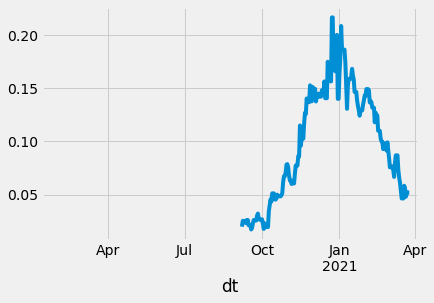

In [109]:
state= 'CT'
df_st_testing_fmt['deaths'][state].diff().shift(-10).div(
    df_st_testing_fmt['hospitalizedIncrease'][state]).rolling(7).mean().plot()